#### **Importing the Libraries**

In [271]:
import numpy as np
from collections import Counter
import yfinance as yf
import pandas as pd
from math import asin, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from math import floor
from fredapi import Fred
import seaborn as sns
import itertools
from qiskit_aer import AerSimulator
from qiskit.providers.basic_provider import BasicProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit_ibm_runtime import SamplerV2 
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator, BicScore, K2Score, HillClimbSearch
import networkx as nx
import pylab as plt
import pyfolio as pf
import heapq

from utils import bit_str_2_arr,encode_data,custom_mcry,prob_to_angle, feature_map, my_trade, quantum_compute

# silence warnings
import warnings
warnings.filterwarnings('ignore')

#### **Starting Quantum Runtime Services**

In [272]:
## Qiskit Runtime service initialization
QiskitRuntimeService.save_account(channel = 'ibm_quantum',
                                  token = 'afbbd92eae66abcc98ea8bfd6269888a2fbeb2cc875b1f30c6cc67ced46d4b5ef84270be2de6c64361ec83180dd3f6f1c616db0debf34cdf5d7816ba9d374597',
                                  instance='ibm-q/open/main',
                                  overwrite=True)
service = QiskitRuntimeService(verify=False)



In [273]:
system_variables = {
                    'start_date': '2019-01-01',  #'2017-01-01
                    'end_date' : '2019-06-30',   #'2017-12-31'
                    'target symbol': "BTC-USD",
                    'feature symbols':["^VIX","NVDA","^GSPC","CNY=X","EUR=X","^TNX"],
                    'initial cash': 10000, #USD
                    'split ratio': 0.7,
                    'num_shots':1000,
                    'seed': 20427891,
                    'sampler': 'v2',
                    'optimization': 1,
                    'Quantum Simulator': AerSimulator(),
                    'Quantum Computer':'least_busy',  
                    # 'Quantum Computer':'ibm_sherbrooke',
                    # 'Quantum Computer':'ibm_osaka',
                    }
scenario = {1:'BUY !!!',0:'HOLD !!!',-1:'SELL !!!'}


#### **Utility Functions**

# **Data Collection & Preprocessing**

[*********************100%%**********************]  7 of 7 completed


Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-02,3943.409424,6.8775,0.87247,3.378612,2510.030029,2.661,23.219999
2019-01-03,3836.741211,6.8611,0.88354,3.174486,2447.889893,2.554,25.450001
2019-01-04,3857.717529,6.8711,0.87788,3.377868,2531.939941,2.659,21.379999
2019-01-07,4025.248291,6.8684,0.87639,3.556695,2549.689941,2.682,21.400000
2019-01-08,4030.847900,6.8500,0.87110,3.468149,2574.409912,2.716,20.469999


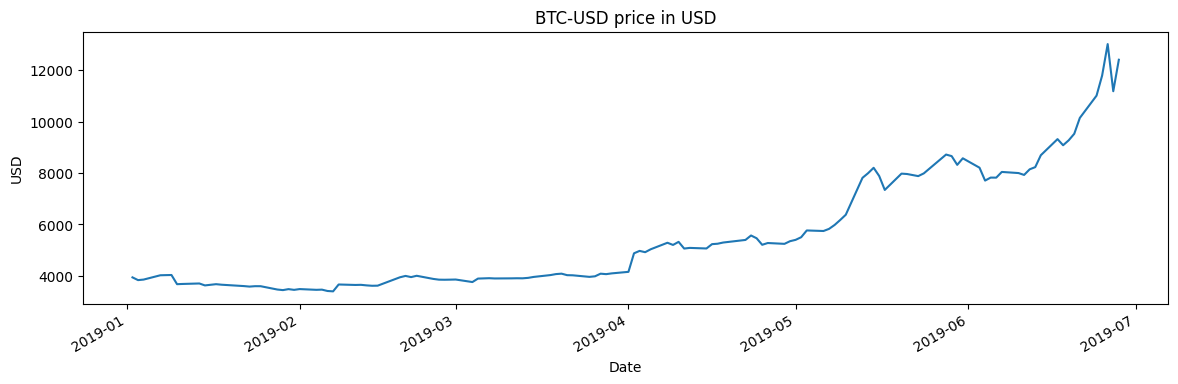

In [274]:
# ^SOX > PHLX semiconductor data
# CNY=X > Yuan to USD forex rate
# EUR=X > EURO to USD forex rate
# ^TNX > CBOE Interest Rate 10 Year T No


tickers = [system_variables['target symbol']] + system_variables['feature symbols']

###### Stock Data Collection #######
###### The trading algoorithm will be designed for this Assets #############
data0 = yf.download(tickers, start= system_variables['start_date'], 
                    end= system_variables['end_date'])['Adj Close']
data0.dropna(inplace=True)

# (data0/data0.iloc[0,:])[target].plot(figsize=(14,4))
data0[system_variables['target symbol']].plot(figsize=(14,4))
plt.title(f"{system_variables['target symbol']} price in USD")
plt.ylabel("USD")
data0.head()

In [275]:
####### removing NaN vaalues from the data set ################
data = data0
data = data.dropna()
print("Number of available samples are",data.shape[0])
print("Number of NaN value on each columns are:\n",data.isna().sum())
# data.head()

Number of available samples are 123
Number of NaN value on each columns are:
 Ticker
BTC-USD    0
CNY=X      0
EUR=X      0
NVDA       0
^GSPC      0
^TNX       0
^VIX       0
dtype: int64


#### **Data Preparation 1:** Converting to Percentage changes data

In [276]:
###### Converting to Percentage changes data ##########
data = data.pct_change().dropna()
data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-03,-0.027050,-0.002385,0.012688,-0.060417,-0.024757,-0.040210,0.096038
2019-01-04,0.005467,0.001457,-0.006406,0.064068,0.034336,0.041112,-0.159921
2019-01-07,0.043427,-0.000393,-0.001697,0.052941,0.007010,0.008650,0.000935
2019-01-08,0.001391,-0.002679,-0.006036,-0.024895,0.009695,0.012677,-0.043458
2019-01-09,0.001104,0.000321,0.002066,0.019667,0.004098,0.004418,-0.023937


#### **Data Preparation 2:** Splitting into training & testing set

In [277]:
#### splitting the data into train and test set
split_ratio = system_variables['split ratio']
split_end = int(data.shape[0]*split_ratio)

train_data = data.iloc[:split_end,:]
test_data = data.iloc[split_end:,:]


print("Size of train data is of {}% is {} samples".format(split_ratio*100,train_data.shape[0]))
print("Size of test data is of {}% is {} samples".format(round((1-split_ratio)*100,2),test_data.shape[0]))

Size of train data is of 70.0% is 85 samples
Size of test data is of 30.0% is 37 samples


#### **Data Preparation 3:** Discretizing/Binarizing the Training Data

In [278]:
########### Discretizing/Binarizing percentage change data #############
 
dscrt_train_data = train_data.applymap(lambda x: 1 if x > 0 else 0)
dscrt_train_data['forecast'] = dscrt_train_data[system_variables['target symbol']].shift(-1)
dscrt_train_data.dropna(inplace=True)
dscrt_train_data['forecast'] = dscrt_train_data['forecast'].apply(np.int64)
dscrt_train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,forecast
Date,,,,,,,,
2019-01-03,0,0,1,0,0,0,1,1
2019-01-04,1,1,0,1,1,1,0,1
2019-01-07,1,0,0,1,1,1,1,1
2019-01-08,1,0,0,0,1,1,0,1
2019-01-09,1,1,1,1,1,1,0,0


In [279]:
####### state distribution of each data columns

for col in dscrt_train_data.columns:
    print("States distribution in {} is {}".format(col,dscrt_train_data[col].value_counts().to_dict()))



States distribution in BTC-USD is {1: 50, 0: 34}
States distribution in CNY=X is {0: 43, 1: 41}
States distribution in EUR=X is {1: 45, 0: 39}
States distribution in NVDA is {1: 49, 0: 35}
States distribution in ^GSPC is {1: 53, 0: 31}
States distribution in ^TNX is {1: 43, 0: 41}
States distribution in ^VIX is {0: 48, 1: 36}
States distribution in forecast is {1: 50, 0: 34}


# **BNSL & QBN Construction**

  0%|          | 0/1000000 [00:00<?, ?it/s]

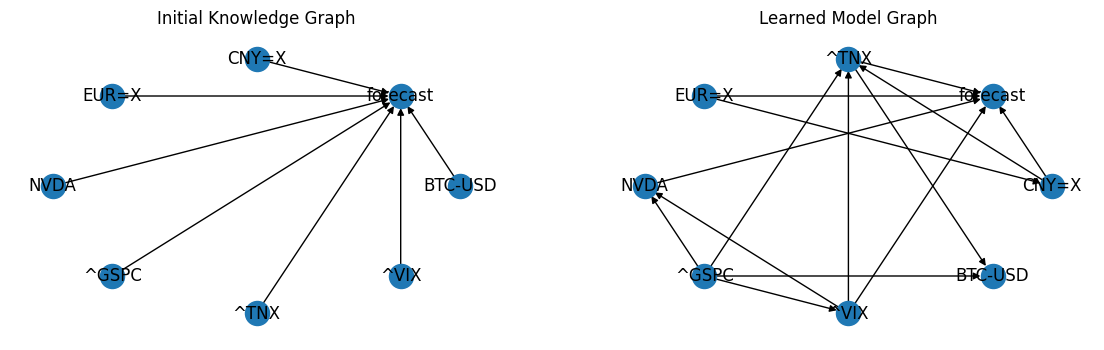

In [280]:
########## Constructing sample knowledge graph of Belief Network #####
 
my_edges = []
for col in dscrt_train_data.columns:
    if col == 'forecast':
        pass
    else:
        my_edges.append((col,'forecast'))
### Sample prior knowledge graph
# print("possible edges will be:",my_edges)

##### Contructing Prior Graph Image using NetworkX ####
G=nx.DiGraph()
G.add_edges_from(my_edges)
label_dict1 = {}
for node in G.nodes():
    label_dict1[node] = node
pos = nx.spring_layout(G)



############ Appliying hillclimb search to best Bayesian network ###########
################## If some prior structure is known ########################

edges = my_edges ## Feeding the prior knowledge graph
model = BayesianNetwork()
model.add_nodes_from(nodes=list(dscrt_train_data.columns))
model.add_edges_from(edges)
hc = HillClimbSearch(dscrt_train_data,state_names=dict(map(lambda e: (e, [0, 1]),dscrt_train_data),
                                                       node_names=list(dscrt_train_data.columns)))
k2 = K2Score(dscrt_train_data)
learned_model = hc.estimate(start_dag=model,scoring_method=k2)
# print("Learned bayesian structure edges are:\n",learned_model.edges())
##### Fitting the Data into Learned Model ###############
learned_model.fit(dscrt_train_data,state_names=dict(map(lambda e: (e, [0, 1]), dscrt_train_data.columns)),
                  estimator=BayesianEstimator, prior_type="K2")

######## Drawing the network ######################
H=nx.DiGraph()
H.add_edges_from(learned_model.edges())
H.add_nodes_from(learned_model.nodes())
label_dict2 = {}
for node in H.nodes():
    label_dict2[node] = node
pos = nx.spring_layout(H)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title("Initial Knowledge Graph")
nx.draw_circular(G,labels=label_dict1,)

plt.subplot(1,2,2)
plt.title("Learned Model Graph")
nx.draw_circular(H,labels=label_dict2,)
plt.show()

#### **Extraction of CPD Table**

In [281]:
### Optimal Belief Network Configurations #########

print('Nodes of the model:',learned_model.nodes())
print('Edges of the model:',learned_model.edges())

#### Printing CPD table of the dataset ###########
for model in learned_model.get_cpds():
    print("\n\nThe CPD table is:\n",model)


Nodes of the model: ['BTC-USD', 'CNY=X', 'EUR=X', 'NVDA', '^GSPC', '^TNX', '^VIX', 'forecast']
Edges of the model: [('CNY=X', 'forecast'), ('CNY=X', '^TNX'), ('EUR=X', 'forecast'), ('EUR=X', 'CNY=X'), ('NVDA', 'forecast'), ('^GSPC', '^VIX'), ('^GSPC', 'NVDA'), ('^GSPC', '^TNX'), ('^GSPC', 'BTC-USD'), ('^TNX', 'forecast'), ('^TNX', 'BTC-USD'), ('^VIX', 'forecast'), ('^VIX', 'NVDA'), ('^VIX', '^TNX')]


The CPD table is:
 +------------+--------------------+-----+--------------------+
| ^GSPC      | ^GSPC(0)           | ... | ^GSPC(1)           |
+------------+--------------------+-----+--------------------+
| ^TNX       | ^TNX(0)            | ... | ^TNX(1)            |
+------------+--------------------+-----+--------------------+
| BTC-USD(0) | 0.6666666666666666 | ... | 0.4166666666666667 |
+------------+--------------------+-----+--------------------+
| BTC-USD(1) | 0.3333333333333333 | ... | 0.5833333333333334 |
+------------+--------------------+-----+--------------------+


The CPD

#### **Traing of Quantum Belief Network:** From CPD Table

In [282]:
#### QuantumCircuit initialization ####
node_list = list(learned_model.nodes())
qc= QuantumCircuit([]) 

for node in node_list:
    qc.add_register(QuantumRegister(1,node)) # Adding qubits with names same as nodes


data_qc = qc.copy()
model_qc = qc.copy()
CPD = []
######### Contructing the QBN from available CPD and ###### 
######### the Learned Belief Network Structure       #######

for i in range(len(learned_model.get_cpds())):
    my_model = learned_model.get_cpds()[i]
    print('\n\nModel state space:',my_model.state_names)



    if len(my_model.variables) == 1:
        cpd = pd.DataFrame(my_model.get_values(),columns=['Probs']).rename_axis(my_model.variable,axis=1)
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Probs'].iloc[0]/cpd['Probs'].iloc[1]))
        # print(cpd)
        CPD.append(cpd)

        data_qc.ry(prob_to_angle(my_model.values[1]),node_list.index(my_model.variable))
    else:
        print('Control:',my_model.variables[1:],'-----------> Target:',my_model.variable)

        lst = np.array(list(itertools.product([0, 1], repeat=len(my_model.variables)-1)))
        cpd = pd.DataFrame(np.array(lst),columns = my_model.variables[1:])
        cpd['Prob_'+ my_model.variable + str(0)] = my_model.get_values()[0,:]
        cpd['Prob_'+ my_model.variable + str(1)] = my_model.get_values()[1,:]
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Prob_'+ my_model.variable + str(0)]/cpd['Prob_'+ my_model.variable + str(1)]))
        # print(cpd)
        CPD.append(cpd)

        for j in range(cpd.shape[0]):
            ctrls = [str(int(z)) for z in cpd.iloc[j,:-3].values]
            ctrls = ''.join(ctrls)
            model_qc = custom_mcry(model_qc,cpd.iloc[j,-1],[node_list.index(j) for j in my_model.variables[1:]],node_list.index(my_model.variable),ctrls)

    model_qc.barrier()



Model state space: {'BTC-USD': [0, 1], '^GSPC': [0, 1], '^TNX': [0, 1]}
Control: ['^GSPC', '^TNX'] -----------> Target: BTC-USD


Model state space: {'CNY=X': [0, 1], 'EUR=X': [0, 1]}
Control: ['EUR=X'] -----------> Target: CNY=X


Model state space: {'EUR=X': [0, 1]}


Model state space: {'NVDA': [0, 1], '^GSPC': [0, 1], '^VIX': [0, 1]}
Control: ['^GSPC', '^VIX'] -----------> Target: NVDA


Model state space: {'^GSPC': [0, 1]}


Model state space: {'^TNX': [0, 1], 'CNY=X': [0, 1], '^GSPC': [0, 1], '^VIX': [0, 1]}
Control: ['CNY=X', '^GSPC', '^VIX'] -----------> Target: ^TNX


Model state space: {'^VIX': [0, 1], '^GSPC': [0, 1]}
Control: ['^GSPC'] -----------> Target: ^VIX


Model state space: {'forecast': [0, 1], 'CNY=X': [0, 1], 'EUR=X': [0, 1], 'NVDA': [0, 1], '^TNX': [0, 1], '^VIX': [0, 1]}
Control: ['CNY=X', 'EUR=X', 'NVDA', '^TNX', '^VIX'] -----------> Target: forecast


In [283]:
CPD[7].head(10)

,CNY=X,EUR=X,NVDA,^TNX,^VIX,Prob_forecast0,Prob_forecast1,theta
0,0,0,0,0,0,0.200000,0.800000,0.927295
1,0,0,0,0,1,0.428571,0.571429,1.427449
2,0,0,0,1,0,0.333333,0.666667,1.230959
3,0,0,0,1,1,0.200000,0.800000,0.927295
4,0,0,1,0,0,0.571429,0.428571,1.714144
5,0,0,1,0,1,0.500000,0.500000,1.570796
6,0,0,1,1,0,0.500000,0.500000,1.570796
7,0,0,1,1,1,0.333333,0.666667,1.230959
8,0,1,0,0,0,0.666667,0.333333,1.910633
9,0,1,0,0,1,0.333333,0.666667,1.230959


#### **Quantum Circuit of Quantum Belief Network**

Depth of the circuit is: 420
Gate operations is:
 OrderedDict([('x', 204), ('unitary', 128), ('ccx', 80), ('mcx_vchain', 64), ('cx', 56), ('cu', 56), ('ry', 24), ('barrier', 8)])


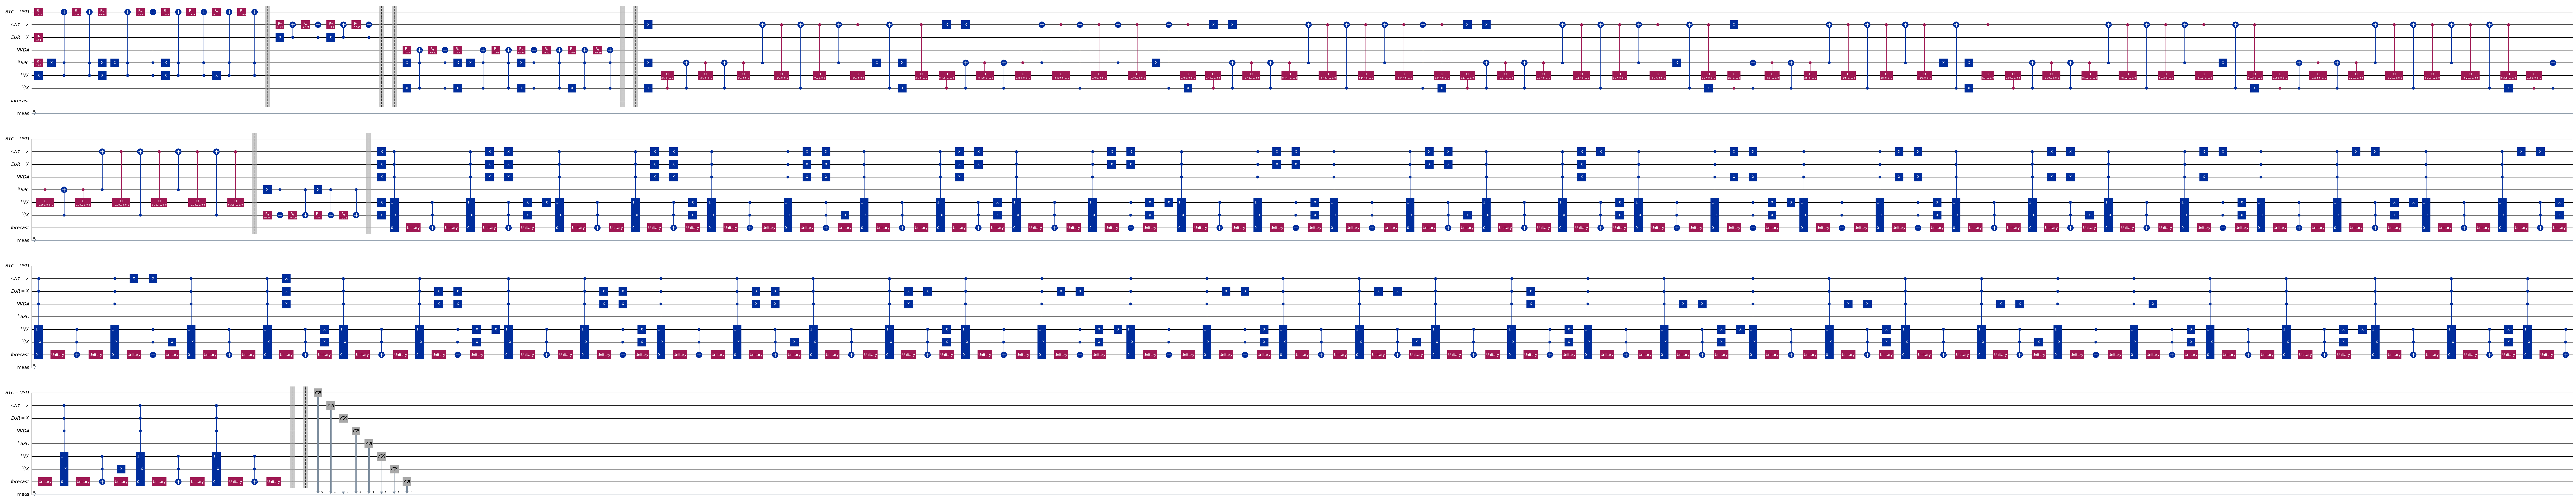

In [284]:
#### Combine the circuit ##############33
qbn_qc = data_qc.compose(model_qc,qubits = range(model_qc.num_qubits))
print("Depth of the circuit is:",model_qc.depth())
print("Gate operations is:\n",model_qc.count_ops())
qbn_qc.measure_all()
qbn_qc.draw('mpl',fold=200)

#### **QBN Execution on IBM Quantum Simulator:** Exploring the Probable Events 

In [285]:
##### Running on simulator #####
backend = AerSimulator()
prob_dist, state = quantum_compute(service,qbn_qc,
                                   backend = system_variables['Quantum Simulator'],
                                   sampler = system_variables['sampler'],
                                   optimization=system_variables['optimization'],
                                   num_shots= system_variables['num_shots'],
                                   seed = system_variables['seed'])
print(f"State with max probability is: {state}")


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.03386 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.12083 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 179.02756 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'11111100': 0.01, '01010010': 0.014, '01011000': 0.004, '01110010': 0.018, '10000000': 0.002, '10010110': 0.011, '01010110': 0.02, '00011110': 0.006, '00010110': 0.005, '11010011': 0.007, '00100001': 0.017, '11011010': 0.008, '11000011': 0.003, '01110101': 0.008, '00100011': 0.018, '10011000': 0.001, '00010010': 0.011, '01010100': 0.022, '10111000': 0.001, '01111000': 0.009, '11010010': 0.051, '11110100': 0.019, '10110101': 0.001, '10100101': 0.02, '10110100': 0.009, '10001001': 0.002, '11010110': 0.017, '00010111': 0.002, '10111100': 0.003, '01010000': 0.01, '00101000': 0.001, '10010010': 0.016, '00001101': 0.003, '00100111': 0.008, '10100111': 0.007, '10000011': 0.004, '00101001': 0.002, '11110010': 0.008, '10010000': 0.003, '01110000': 0.029, '11010100': 0.023, '00101101': 0.005, '00001001': 0.001, '10000010': 0.006, '10101010': 0.002, '01010001': 0.002, '01011110'



 State with max probability is: 11010010


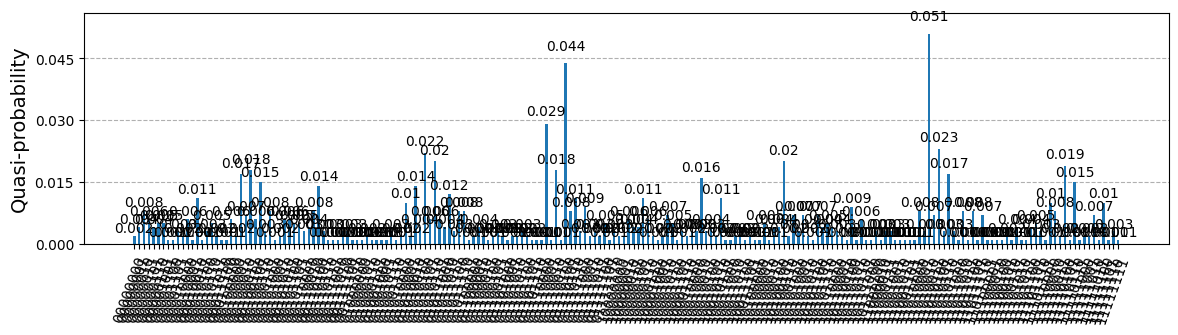

In [286]:
######## Plotting the distribution #############
print(f"\n\n State with max probability is: {state}")

m = 400 # take m largest probability values
top_keys = heapq.nlargest(m, prob_dist, key=prob_dist.get)
top_states = {key: prob_dist[key] for key in top_keys}
plot_histogram(top_states,figsize=(14,3))

# **Forecasting with Trained QBN on Training Data**

In [287]:
train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-03,-0.027050,-0.002385,0.012688,-0.060417,-0.024757,-0.040210,0.096038
2019-01-04,0.005467,0.001457,-0.006406,0.064068,0.034336,0.041112,-0.159921
2019-01-07,0.043427,-0.000393,-0.001697,0.052941,0.007010,0.008650,0.000935
2019-01-08,0.001391,-0.002679,-0.006036,-0.024895,0.009695,0.012677,-0.043458
2019-01-09,0.001104,0.000321,0.002066,0.019667,0.004098,0.004418,-0.023937


#### **Scaling the Training Data:** Adjusting the Reference Level of Percentage Change Data

In [288]:
############ Shifting the mean/referenc e level of the data 
transformed_train_data = train_data.apply(lambda x: (x + 0.5),axis=1)
transformed_train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-03,0.472950,0.497615,0.512688,0.439583,0.475243,0.459790,0.596038
2019-01-04,0.505467,0.501457,0.493594,0.564068,0.534336,0.541112,0.340079
2019-01-07,0.543427,0.499607,0.498303,0.552941,0.507010,0.508650,0.500935
2019-01-08,0.501391,0.497321,0.493964,0.475105,0.509695,0.512677,0.456542
2019-01-09,0.501104,0.500321,0.502066,0.519667,0.504098,0.504418,0.476063


In [289]:
transformed_train_data.describe()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.504871,0.499754,0.500293,0.503724,0.501860,0.499364,0.497183
std,0.030130,0.002311,0.003686,0.029434,0.007640,0.014054,0.064033
min,0.411686,0.493930,0.491277,0.361755,0.475243,0.459790,0.340079
25%,0.494127,0.498059,0.498238,0.492545,0.497876,0.488979,0.459524
50%,0.501397,0.500000,0.500168,0.505088,0.501232,0.500369,0.488636
75%,0.511039,0.500968,0.502066,0.518184,0.506609,0.508650,0.528081
max,0.673560,0.507058,0.512688,0.569703,0.534336,0.541112,0.709098


#### **Converting Training Data to Quantum Data:** Scaling the Percentage Change Data between 0 to $\pi$ for $R_{y}(\theta)$ Gate

In [290]:
####### The Quantum Data: Angle data over bloch sphere ##############
train_angle_data = 2*np.arctan(np.sqrt((transformed_train_data)/(1-transformed_train_data)))
train_angle_data['actual'] = dscrt_train_data['forecast']
train_angle_data.dropna(inplace=True)
train_angle_data['actual'] = train_angle_data['actual'].apply(np.int64)
train_angle_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2019-01-03,1.516670,1.566027,1.596175,1.449666,1.521263,1.490288,1.764073,1
2019-01-04,1.581731,1.573711,1.557984,1.699285,1.639522,1.653113,1.245233,1
2019-01-07,1.657761,1.570010,1.567402,1.676877,1.584818,1.588097,1.572667,1
2019-01-08,1.573579,1.565438,1.558724,1.520985,1.590188,1.596153,1.483771,1
2019-01-09,1.573004,1.571439,1.574929,1.610140,1.578993,1.579633,1.522903,0


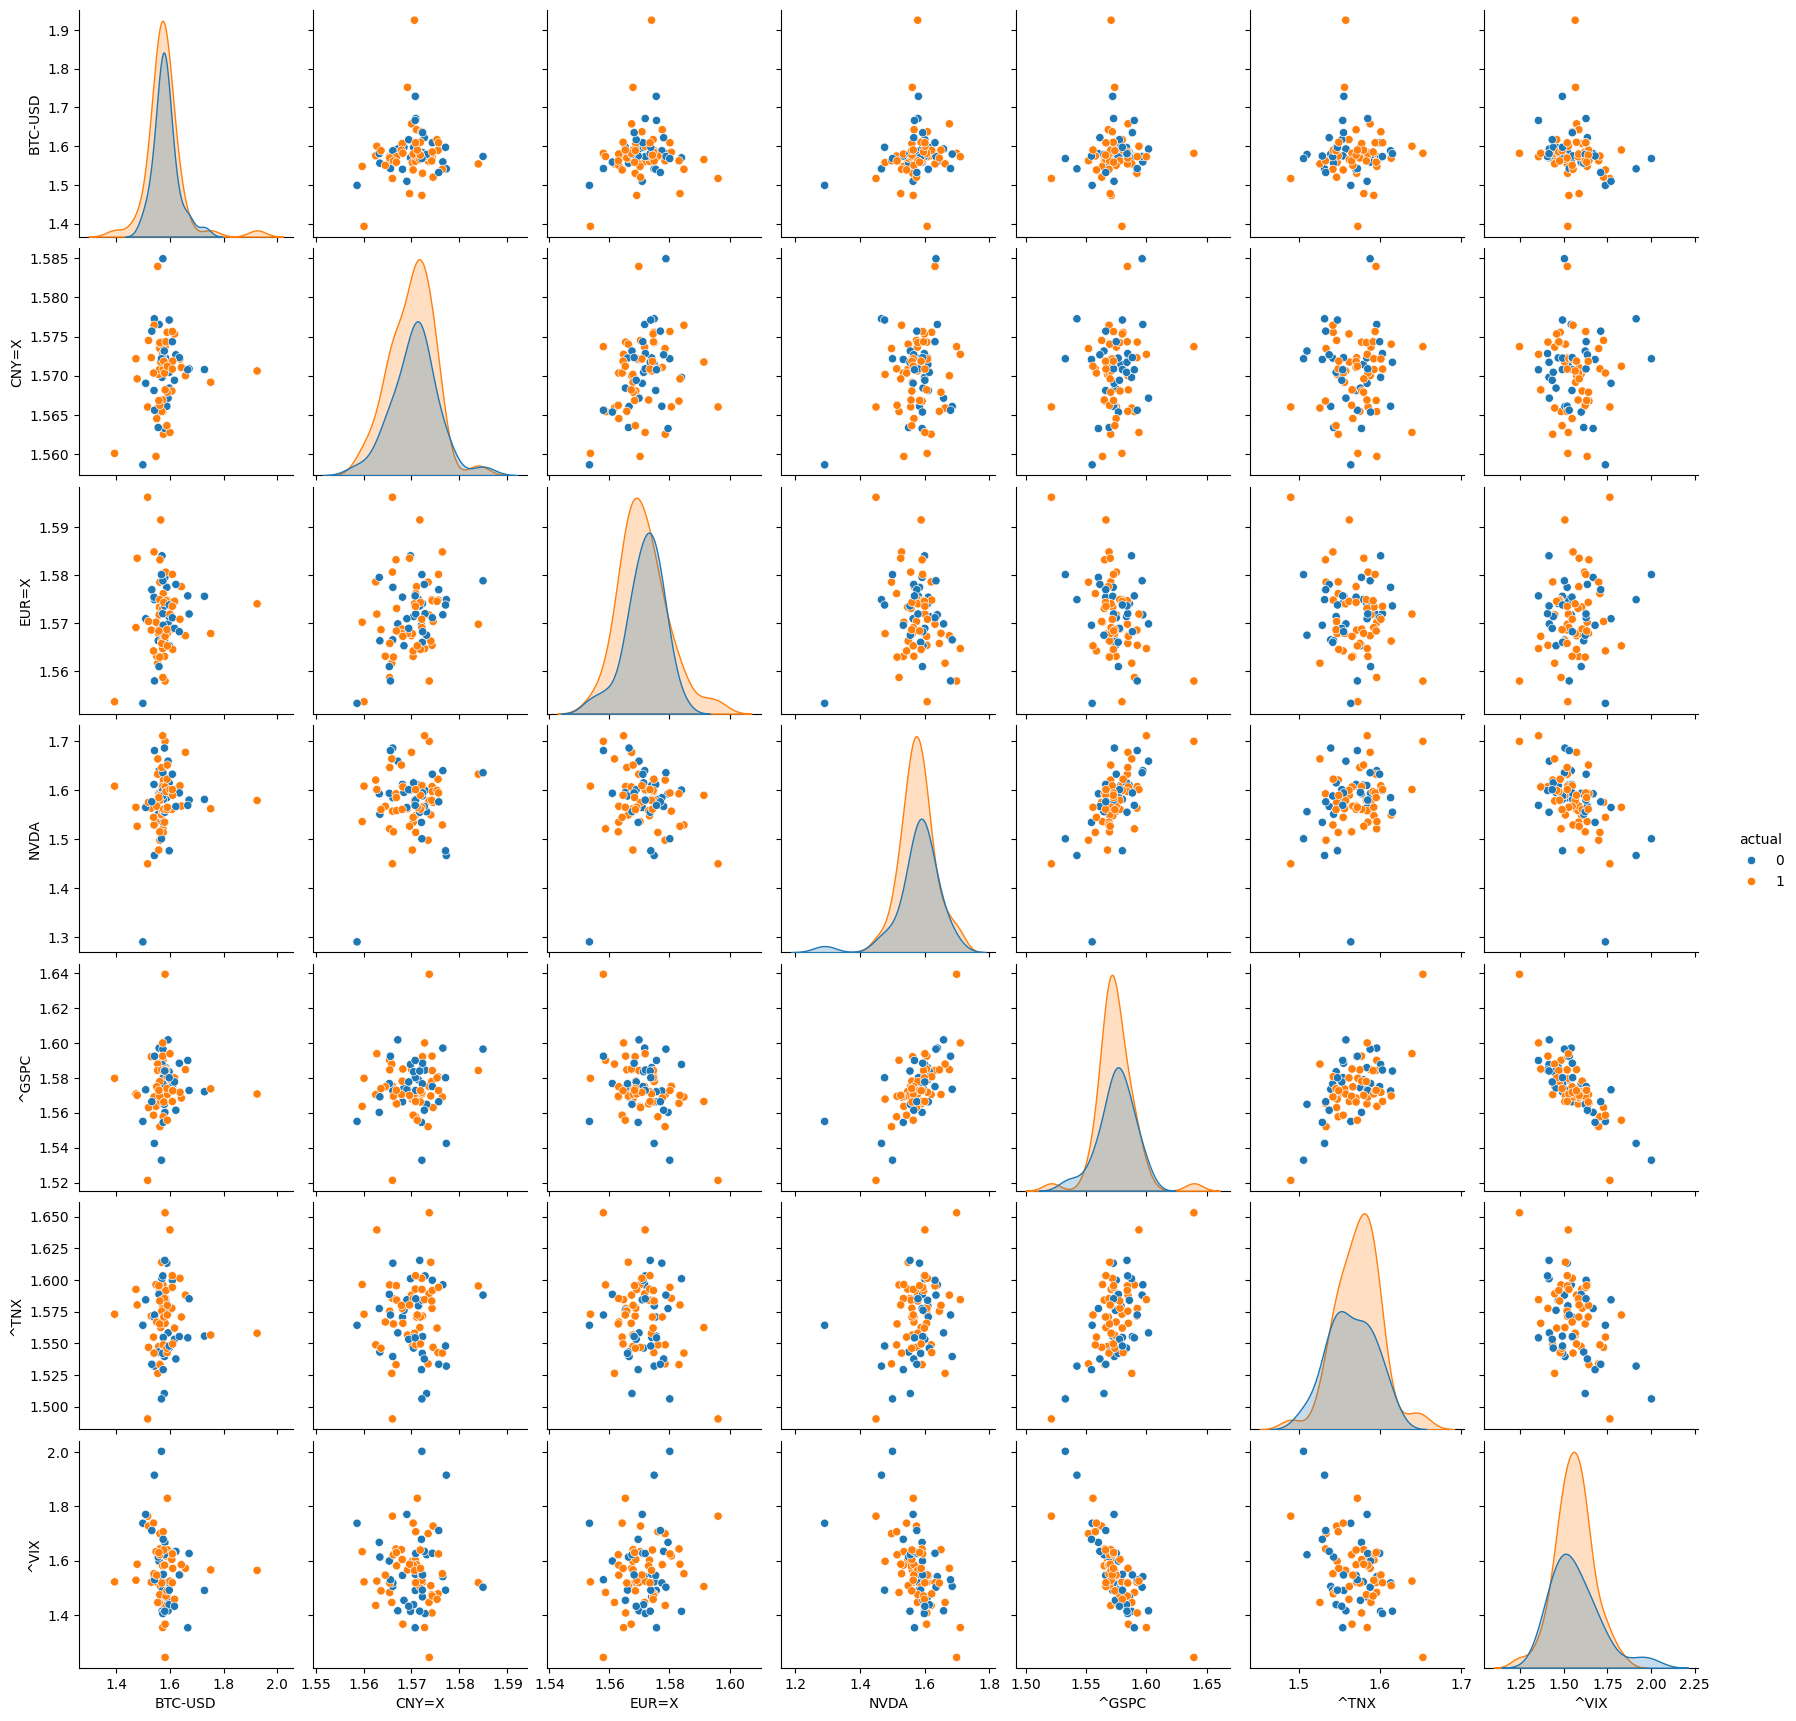

In [291]:
sns.pairplot(train_angle_data,hue='actual');

In [292]:
####### The Quantum Data: Angle data over bloch sphere ##############
train_quantum_data = train_angle_data.applymap(lambda x: (np.pi/4-(x/4)) if x < np.pi/2 else ((3*np.pi/4)+(x/4)))#,axis=1)
train_quantum_data['actual'] = dscrt_train_data['forecast']
train_quantum_data.dropna(inplace=True)
train_quantum_data['actual'] = train_quantum_data['actual'].apply(np.int64)
train_quantum_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2019-01-03,0.406231,0.393891,2.755238,0.422982,0.405083,0.412826,2.797213,1
2019-01-04,2.751627,2.749622,0.395902,2.781016,2.766075,2.769473,0.474090,1
2019-01-07,2.770635,0.392896,0.393548,2.775414,2.752399,2.753219,2.749361,1
2019-01-08,2.749589,0.394039,0.395717,0.405152,2.753742,2.755233,0.414456,1
2019-01-09,2.749445,2.749054,2.749927,2.758729,2.750943,2.751103,0.404672,0


In [293]:
train_quantum_data.iloc[:,:-1].describe()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,1.803907,1.627764,1.656355,1.777580,1.882063,1.688575,1.425740
std,1.164418,1.183662,1.182201,1.168891,1.144074,1.179004,1.173939
min,0.392852,0.392707,0.392807,0.393190,0.392764,0.393692,0.393705
25%,0.399939,0.393804,0.393873,0.401698,0.395251,0.398801,0.408951
50%,2.749726,2.748894,2.749009,2.751456,2.749545,2.749183,0.432513
75%,2.754659,2.749384,2.749957,2.758038,2.752214,2.753255,2.762646
max,2.837518,2.752423,2.755238,2.783859,2.766075,2.769473,2.856758


In [294]:
i = 6
print((train_data.iloc[:,i].apply(lambda x: 0 if x <= 0 else 1)).value_counts())
print((transformed_train_data.iloc[:,i].apply(lambda x: 0 if x <= 0.5 else 1)).value_counts())
print((train_quantum_data.iloc[:,i].apply(lambda x: 0 if x <= np.pi/2 else 1)).value_counts())

^VIX
0    48
1    37
Name: count, dtype: int64
^VIX
0    48
1    37
Name: count, dtype: int64
^VIX
0    48
1    36
Name: count, dtype: int64


#### **Bloch Sphere Representation:** of one Quantum Data Sample

Binarized classical data: {'BTC-USD': 0, 'CNY=X': 0, 'EUR=X': 0, 'NVDA': 0, '^GSPC': 0, '^TNX': 0, '^VIX': 1}
Data values: Ticker
BTC-USD    0.395917
CNY=X      0.392855
EUR=X      0.393441
NVDA       0.415955
^GSPC      0.393427
^TNX       0.398531
^VIX       2.755784
Name: 2019-01-29 00:00:00, dtype: float64


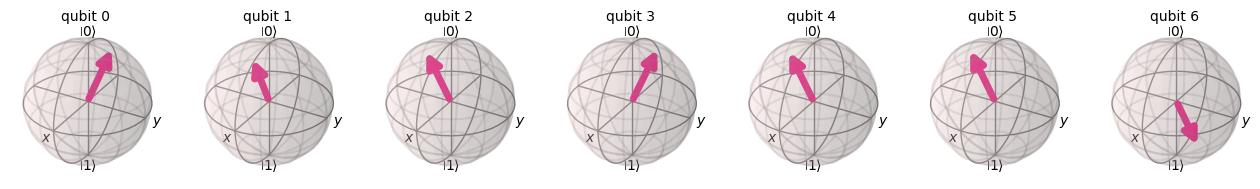

In [295]:
################ Plotting one sample quantum train data row 
################ Individual bloch sphere corresponding to each variables ##########
r = 17 # row number
bloch_sp_data= QuantumCircuit([])
for i in range(train_quantum_data.shape[1]-1):
    bloch_sp_data.add_register(QuantumRegister(1,train_quantum_data.columns[i]))
    bloch_sp_data.ry(train_quantum_data.iloc[r,i],i)
    bloch_sp_data.rz(train_data.iloc[r,i]*100*2*np.pi,i)
    # bloch_sp_data.rx(10*train_data.iloc[r,i],i)

print("Binarized classical data:",dict(dscrt_train_data.iloc[r,:-1]))
print("Data values:",train_quantum_data.iloc[r,:-1])
plot_bloch_multivector(Statevector(bloch_sp_data))


#### **QBN Strategy on Quantum Training Data Set:** Forecasting Price Movements & Implementation of QBN Trading Strategy using Qiskit Aer Quantum Simulator

In [298]:
initial_cash = system_variables['initial cash']


SIGNALS_TRAIN = []
STATES_TRAIN = []
BUY_PRICE_TRAIN = []
SELL_PRICE_TRAIN = []
POSITIONS_TRAIN = []
PORT_VALUE_TRAIN = []
CASH_TRAIN = []

train_log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
       'position':0,'portfolio value':initial_cash,'cash':initial_cash,
       'last purchase price': 0}

z = 0

for i in range(z,train_quantum_data.shape[0]):
    price = data0.loc[train_quantum_data.index[i]][0]
    row = np.append(train_quantum_data.iloc[i,:data.shape[1]].values,0)   
    my_data = encode_data(row,method='default') 
    qbn_circuit = my_data.compose(model_qc,qubits = range(my_data.num_qubits))#,clbits=[0,])
    cr = ClassicalRegister(1)

    qbn_circuit.add_register(cr)
    qbn_circuit.measure(-1,0)

    prob_dist, state = quantum_compute(service,qbn_circuit,
                                       backend = system_variables['Quantum Simulator'],
                                       sampler = system_variables['sampler'],
                                       optimization=system_variables['optimization'],
                                       num_shots= system_variables['num_shots'],
                                       seed = system_variables['seed'])

    if i == 0:
        train_log['state'] = state
        if state == 1:
            signal = 1
        else:
            signal = train_log['signal']

        state = train_log['state']
        buy_price, sell_price = train_log['buy_price'],train_log['sell_price']
        position, port_value, cash = train_log['position'],train_log['portfolio value'],train_log['cash']             
        new_log = train_log

    elif i == train_quantum_data.shape[0]-1:
        new_log = my_trade(state,price,train_log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        if new_log['position'] > 0:
            cash = new_log['position']*price
            position = 0
            port_value = cash
        else:
            position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    else:
        new_log = my_trade(state,price,train_log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    train_log = new_log
    SIGNALS_TRAIN.append(signal)
    BUY_PRICE_TRAIN.append(buy_price)
    SELL_PRICE_TRAIN.append(sell_price)
    STATES_TRAIN.append(state)
    POSITIONS_TRAIN.append(position)
    PORT_VALUE_TRAIN.append(port_value)
    CASH_TRAIN.append(cash)



    print("\n\n{}: The signal for the next day is {} with expected price movement of {}"
          .format(train_quantum_data.index[i].date(),scenario[signal],state))
    print("Probability distributions are:",prob_dist)
    print(train_log,'\n\n')


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.15850 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 152.60243 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.78458 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)


The output probability distribution: {'1': 0.59, '0': 0.41}


2019-01-03: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.59, '0': 0.41}
{'state': 1, 'buy_price': nan, 'sell_price': nan, 'signal': 0, 'position': 0, 'portfolio value': 10000, 'cash': 10000, 'last purchase price': 0} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 200.74677 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.441, '0': 0.559}


2019-01-04: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.441, '0': 0.559}
{'state': 0, 'signal': -1, 'position': 0, 'cash': 10000, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 10000.0} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.24910 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 119.97294 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.54855 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)


The output probability distribution: {'1': 0.373, '0': 0.627}


2019-01-07: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.373, '0': 0.627}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10000, 'last purchase price': 0, 'portfolio value': 10000.0} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 95.09993 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.41, '0': 0.59}


2019-01-08: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10000, 'last purchase price': 0, 'portfolio value': 10000.0} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 87.56447 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.592, '0': 0.408}


2019-01-09: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.592, '0': 0.408}
{'state': 1, 'signal': 1, 'position': 2.4781327173172953, 'cash': 0, 'buy_price': 4035.29638671875, 'sell_price': nan, 'last purchase price': 4035.29638671875, 'portfolio value': 10000.0} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.83735 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.15926 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 92.31472 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.457, '0': 0.543}


2019-01-10: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.457, '0': 0.543}
{'state': 0, 'signal': -1, 'position': 2.4781327173172953, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 4035.29638671875, 'portfolio value': 9116.863318033364} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 82.63874 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.28183 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 92.43488 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.545, '0': 0.455}


2019-01-11: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.545, '0': 0.455}
{'state': 1, 'signal': 1, 'position': 2.4781327173172953, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 9137.781033015915} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.039s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 62.73675 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.12070 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.83293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.02958 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 50.48895 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.12280 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.88266 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.97070 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.00319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.515, '0': 0.485}


2019-01-14: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.515, '0': 0.485}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.4781327173172953, 'cash': 0, 'last purchase price': 0, 'portfolio value': 9184.08932313217} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 105.82137 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.84228 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 103.51443 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.389, '0': 0.611}


2019-01-15: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.389, '0': 0.611}
{'state': 0, 'signal': -1, 'cash': 8997.295229461415, 'position': 0, 'buy_price': nan, 'sell_price': 3630.67529296875, 'last purchase price': 0, 'portfolio value': 8997.295229461415} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.002s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.022s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.038s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 84.36656 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.57687 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.81257 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.64828 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 64.22710 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 19.50288 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 23.37742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.559, '0': 0.441}


2019-01-16: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.559, '0': 0.441}
{'state': 1, 'signal': 1, 'position': 2.4616356776672434, 'cash': 0, 'buy_price': 3655.0068359375, 'sell_price': nan, 'last purchase price': 3655.0068359375, 'portfolio value': 8997.295229461415} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 100.67487 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.76821 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)


The output probability distribution: {'1': 0.594, '0': 0.406}


2019-01-17: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.4616356776672434, 'cash': 0, 'last purchase price': 3655.0068359375, 'portfolio value': 9055.284298440447} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 200.79613 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.90203 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 97.76163 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.591, '0': 0.409}


2019-01-18: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.591, '0': 0.409}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.4616356776672434, 'cash': 0, 'last purchase price': 3655.0068359375, 'portfolio value': 9004.267860597229} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.040s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 66.17570 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.96747 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.91946 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.70757 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.75827 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.12654 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.71619 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.37815 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.48711 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.596, '0': 0.404}


2019-01-22: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.596, '0': 0.404}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.4616356776672434, 'cash': 0, 'last purchase price': 3655.0068359375, 'portfolio value': 8873.155711497806} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 91.54987 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.87421 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 89.26463 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.594, '0': 0.406}


2019-01-23: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.4616356776672434, 'cash': 0, 'last purchase price': 3655.0068359375, 'portfolio value': 8825.266801014594} 




INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.62980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.63583 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.41678 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 59.05151 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.41753 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.81521 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.86865 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.60377 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
base_primitive._run:INFO:2024-08-06 01:14:08,456: Submitting job using options {'opti

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.415, '0': 0.585}


2019-01-24: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.415, '0': 0.585}
{'state': 0, 'signal': -1, 'position': 2.4616356776672434, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 3655.0068359375, 'portfolio value': 8864.018932394394} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 93.53495 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.17733 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 125.66614 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.584, '0': 0.416}


2019-01-25: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.584, '0': 0.416}
{'state': 1, 'signal': 1, 'position': 2.4616356776672434, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 8861.312094725396} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.010s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.041s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 70.21356 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.38740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.78253 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.09420 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.14432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.96208 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 21.48652 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.98500 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.pas

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.458, '0': 0.542}


2019-01-28: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.458, '0': 0.542}
{'state': 0, 'signal': -1, 'cash': 8542.984619333776, 'position': 0, 'buy_price': nan, 'sell_price': 3470.450439453125, 'last purchase price': 0, 'portfolio value': 8542.984619333776} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 101.32384 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.66285 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)


The output probability distribution: {'1': 0.457, '0': 0.543}


2019-01-29: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.457, '0': 0.543}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8542.984619333776, 'last purchase price': 0, 'portfolio value': 8542.984619333776} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 179.98600 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.414, '0': 0.586}


2019-01-30: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.414, '0': 0.586}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8542.984619333776, 'last purchase price': 0, 'portfolio value': 8542.984619333776} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 113.65414 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.45471 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)


The output probability distribution: {'1': 0.415, '0': 0.585}


2019-01-31: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.415, '0': 0.585}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8542.984619333776, 'last purchase price': 0, 'portfolio value': 8542.984619333776} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 140.54513 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.583, '0': 0.417}


2019-02-01: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.583, '0': 0.417}
{'state': 1, 'signal': 1, 'position': 2.449288579358647, 'cash': 0, 'buy_price': 3487.9453125, 'sell_price': nan, 'last purchase price': 3487.9453125, 'portfolio value': 8542.984619333776} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 95.50548 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.04890 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 125.62180 (ms)


The output probability distribution: {'1': 0.441, '0': 0.559}


2019-02-04: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.441, '0': 0.559}
{'state': 0, 'signal': -1, 'position': 2.449288579358647, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 3487.9453125, 'portfolio value': 8472.466515604483} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3', 'pauli', 'rzx', 'rx', 'tdg', 'save_probabilities_dict', 'u3', 'cu', 'mcrz

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.62244 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 84.04088 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.603, '0': 0.397}


2019-02-05: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.603, '0': 0.397}
{'state': 1, 'signal': 1, 'position': 2.449288579358647, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 8490.10964537352} 




INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.16941 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.30257 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 86.11178 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 21.76476 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 30.61604 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.41084 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.21865 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
base_primitive._run:INFO:2024-08-06 01:14:14,282: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.81923 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 134.37366 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.545, '0': 0.455}


2019-02-06: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.545, '0': 0.455}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.449288579358647, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8361.302539657234} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.008s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.045s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 66.80131 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.99618 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.59704 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.76096 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.83819 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.77423 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 13.71264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.14056 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01597 (ms)
INFO:qiskit.pa

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.596, '0': 0.404}


2019-02-07: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.596, '0': 0.404}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.449288579358647, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8326.28716091175} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 105.61419 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.85745 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 110.98409 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.604, '0': 0.396}


2019-02-08: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.604, '0': 0.396}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.449288579358647, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8981.003046748045} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.012s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.049s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 84.58328 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.49104 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.60188 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.41470 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.99542 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.91893 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.53578 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.27849 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.pas

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.559, '0': 0.441}


2019-02-11: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.559, '0': 0.441}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.449288579358647, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8936.059558070165} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 106.16255 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.592, '0': 0.408}


2019-02-12: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.592, '0': 0.408}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.449288579358647, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8948.54578727563} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.38190 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 165.52377 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('rccx', 3), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.373, '0': 0.627}


2019-02-13: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.373, '0': 0.627}
{'state': 0, 'signal': -1, 'cash': 8895.988933804687, 'position': 0, 'buy_price': nan, 'sell_price': 3632.070556640625, 'last purchase price': 0, 'portfolio value': 8895.988933804687} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 103.91331 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.525, '0': 0.475}


2019-02-14: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.525, '0': 0.475}
{'state': 1, 'signal': 1, 'position': 2.459574777185755, 'cash': 0, 'buy_price': 3616.880859375, 'sell_price': nan, 'last purchase price': 3616.880859375, 'portfolio value': 8895.988933804687} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.72784 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 177.28233 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.441, '0': 0.559}


2019-02-15: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.441, '0': 0.559}
{'state': 0, 'signal': -1, 'cash': 8905.654894544032, 'position': 0, 'buy_price': nan, 'sell_price': 3620.810791015625, 'last purchase price': 0, 'portfolio value': 8905.654894544032} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 107.42378 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.71638 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 100.35014 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.464, '0': 0.536}


2019-02-19: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.464, '0': 0.536}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8905.654894544032, 'last purchase price': 0, 'portfolio value': 8905.654894544032} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.040s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 67.76834 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.33504 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.89099 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.63255 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 77.87108 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 22.35293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 43.07437 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.71172 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.93558 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.458, '0': 0.542}


2019-02-20: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.458, '0': 0.542}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8905.654894544032, 'last purchase price': 0, 'portfolio value': 8905.654894544032} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 109.68828 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 10.14328 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)


The output probability distribution: {'1': 0.41, '0': 0.59}


2019-02-21: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8905.654894544032, 'last purchase price': 0, 'portfolio value': 8905.654894544032} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 216.64357 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.599, '0': 0.401}


2019-02-22: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.599, '0': 0.401}
{'state': 1, 'signal': 1, 'position': 2.2233418370902185, 'cash': 0, 'buy_price': 4005.526611328125, 'sell_price': nan, 'last purchase price': 4005.526611328125, 'portfolio value': 8905.654894544032} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 7.61962 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 135.38170 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.01521 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)


The output probability distribution: {'1': 0.559, '0': 0.441}


2019-02-25: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.559, '0': 0.441}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.2233418370902185, 'cash': 0, 'last purchase price': 4005.526611328125, 'portfolio value': 8632.561100187593} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 286.48710 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.93970 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 111.84144 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.456, '0': 0.544}


2019-02-26: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.456, '0': 0.544}
{'state': 0, 'signal': -1, 'position': 2.2233418370902185, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 4005.526611328125, 'portfolio value': 8569.555196770012} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.043s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 69.63849 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 11.43956 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.73382 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 5.41234 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 291.16511 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 70.37520 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 75.62375 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 28.94354 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 18.69965 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Fixed

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.389, '0': 0.611}


2019-02-27: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.389, '0': 0.611}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.2233418370902185, 'cash': 0, 'last purchase price': 4005.526611328125, 'portfolio value': 8562.194719399176} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.74356 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 96.33994 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.582, '0': 0.418}


2019-02-28: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.582, '0': 0.418}
{'state': 1, 'signal': 1, 'position': 2.2233418370902185, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 8570.505653693046} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 105.77226 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.594, '0': 0.406}


2019-03-01: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.2233418370902185, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8581.174003416232} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.61242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 97.96119 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.373, '0': 0.627}


2019-03-04: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.373, '0': 0.627}
{'state': 0, 'signal': -1, 'cash': 8363.227337302229, 'position': 0, 'buy_price': nan, 'sell_price': 3761.55712890625, 'last purchase price': 0, 'portfolio value': 8363.227337302229} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 153.59187 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.594, '0': 0.406}


2019-03-05: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 1, 'position': 2.1464123287163654, 'cash': 0, 'buy_price': 3896.375, 'sell_price': nan, 'last purchase price': 3896.375, 'portfolio value': 8363.227337302229} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.36378 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 90.00063 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.596, '0': 0.404}


2019-03-06: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.596, '0': 0.404}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1464123287163654, 'cash': 0, 'last purchase price': 3896.375, 'portfolio value': 8379.470585093542} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 122.94459 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 5.37229 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)


The output probability distribution: {'1': 0.44, '0': 0.56}


2019-03-07: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.44, '0': 0.56}
{'state': 0, 'signal': -1, 'cash': 8395.658286081427, 'position': 0, 'buy_price': nan, 'sell_price': 3911.484375, 'last purchase price': 0, 'portfolio value': 8395.658286081427} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 117.10167 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 7.62248 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)


The output probability distribution: {'1': 0.526, '0': 0.474}


2019-03-08: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.526, '0': 0.474}
{'state': 1, 'signal': 1, 'position': 2.1521084558478987, 'cash': 0, 'buy_price': 3901.131591796875, 'sell_price': nan, 'last purchase price': 3901.131591796875, 'portfolio value': 8395.658286081427} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 332.88240 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.441, '0': 0.559}


2019-03-11: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.441, '0': 0.559}
{'state': 0, 'signal': -1, 'cash': 8404.472683409384, 'position': 0, 'buy_price': nan, 'sell_price': 3905.227294921875, 'last purchase price': 0, 'portfolio value': 8404.472683409384} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 100.01874 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.41, '0': 0.59}


2019-03-12: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8404.472683409384, 'last purchase price': 0, 'portfolio value': 8404.472683409384} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.87294 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 100.69752 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.34287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)


The output probability distribution: {'1': 0.456, '0': 0.544}


2019-03-13: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.456, '0': 0.544}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8404.472683409384, 'last purchase price': 0, 'portfolio value': 8404.472683409384} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 537.48798 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.24242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)


The output probability distribution: {'1': 0.41, '0': 0.59}


2019-03-14: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8404.472683409384, 'last purchase price': 0, 'portfolio value': 8404.472683409384} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 517.66539 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.57008 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)


The output probability distribution: {'1': 0.603, '0': 0.397}


2019-03-15: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.603, '0': 0.397}
{'state': 1, 'signal': 1, 'position': 2.121853382113542, 'cash': 0, 'buy_price': 3960.9111328125, 'sell_price': nan, 'last purchase price': 3960.9111328125, 'portfolio value': 8404.472683409384} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 2644.53173 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'c

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.34637 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)


The output probability distribution: {'1': 0.359, '0': 0.641}


2019-03-18: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.359, '0': 0.641}
{'state': 0, 'signal': -1, 'cash': 8556.389304291184, 'position': 0, 'buy_price': nan, 'sell_price': 4032.50732421875, 'last purchase price': 0, 'portfolio value': 8556.389304291184} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 241.60337 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 7.22051 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)


The output probability distribution: {'1': 0.484, '0': 0.516}


2019-03-19: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.484, '0': 0.516}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8556.389304291184, 'last purchase price': 0, 'portfolio value': 8556.389304291184} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 209.32770 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 8.25548 (ms)


The output probability distribution: {'1': 0.44, '0': 0.56}


2019-03-20: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.44, '0': 0.56}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8556.389304291184, 'last purchase price': 0, 'portfolio value': 8556.389304291184} 




INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 229.70819 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.84714 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02337 (ms)


The output probability distribution: {'1': 0.456, '0': 0.544}


2019-03-21: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.456, '0': 0.544}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 8556.389304291184, 'last purchase price': 0, 'portfolio value': 8556.389304291184} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 251.79935 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.75190 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 113.99627 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.595, '0': 0.405}


2019-03-22: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.595, '0': 0.405}
{'state': 1, 'signal': 1, 'position': 2.1263560614259194, 'cash': 0, 'buy_price': 4023.96826171875, 'sell_price': nan, 'last purchase price': 4023.96826171875, 'portfolio value': 8556.389304291184} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.011s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.059s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 87.07619 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.49628 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.71086 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.34692 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 55.56321 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 22.25208 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 32.02271 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.35044 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01597 (ms)
INFO:qiskit.pa

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.55, '0': 0.45}


2019-03-25: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.55, '0': 0.45}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1263560614259194, 'cash': 0, 'last purchase price': 4023.96826171875, 'portfolio value': 8426.899099971386} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.54846 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 382.74431 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.412, '0': 0.588}


2019-03-26: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.412, '0': 0.588}
{'state': 0, 'signal': -1, 'position': 2.1263560614259194, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 4023.96826171875, 'portfolio value': 8473.700736778463} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.48932 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 119.84897 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_mat

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.17352 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)


The output probability distribution: {'1': 0.596, '0': 0.404}


2019-03-27: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.596, '0': 0.404}
{'state': 1, 'signal': 1, 'position': 2.1263560614259194, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 8690.557907250039} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 241.75286 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.594, '0': 0.406}


2019-03-28: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1263560614259194, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8652.370711967204} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 95.53885 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.594, '0': 0.406}


2019-03-29: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1263560614259194, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8714.603484986657} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.63946 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 86.09772 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('rccx', 3), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.53958 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01669 (ms)


The output probability distribution: {'1': 0.582, '0': 0.418}


2019-04-01: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.582, '0': 0.418}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1263560614259194, 'cash': 0, 'last purchase price': 0, 'portfolio value': 8841.77785083233} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 230.45349 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.599, '0': 0.401}


2019-04-02: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.599, '0': 0.401}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1263560614259194, 'cash': 0, 'last purchase price': 0, 'portfolio value': 10376.358014809583} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.85349 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 94.23661 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.561, '0': 0.439}


2019-04-03: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.561, '0': 0.439}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1263560614259194, 'cash': 0, 'last purchase price': 0, 'portfolio value': 10574.4154151619} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 104.49076 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.76821 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 89.54906 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.464, '0': 0.536}


2019-04-04: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.464, '0': 0.536}
{'state': 0, 'signal': -1, 'cash': 10467.623127364006, 'position': 0, 'buy_price': nan, 'sell_price': 4922.798828125, 'last purchase price': 0, 'portfolio value': 10467.623127364006} 




INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 51.17583 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.83467 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.75955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.79395 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 66.57553 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 17.79222 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.46735 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.92175 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.63898 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.05651 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02360 (ms)
base_primit

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.604, '0': 0.396}


2019-04-05: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.604, '0': 0.396}
{'state': 1, 'signal': 1, 'position': 2.0782778998216003, 'cash': 0, 'buy_price': 5036.68115234375, 'sell_price': nan, 'last purchase price': 5036.68115234375, 'portfolio value': 10467.623127364006} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 111.63521 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.30512 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 104.11859 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.561, '0': 0.439}


2019-04-08: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.561, '0': 0.439}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.0782778998216003, 'cash': 0, 'last purchase price': 5036.68115234375, 'portfolio value': 10993.614156298932} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.011s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.047s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 76.06435 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.67796 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.73540 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.31712 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.57617 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.39173 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 13.65757 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.85063 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.pa

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.452, '0': 0.548}


2019-04-09: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.452, '0': 0.548}
{'state': 0, 'signal': -1, 'cash': 10817.350211920313, 'position': 0, 'buy_price': nan, 'sell_price': 5204.95849609375, 'last purchase price': 0, 'portfolio value': 10817.350211920313} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 117.17796 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 7.19547 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)


The output probability distribution: {'1': 0.413, '0': 0.587}


2019-04-10: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.413, '0': 0.587}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10817.350211920313, 'last purchase price': 0, 'portfolio value': 10817.350211920313} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 164.55626 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.389, '0': 0.611}


2019-04-11: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.389, '0': 0.611}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10817.350211920313, 'last purchase price': 0, 'portfolio value': 10817.350211920313} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 98.17123 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.15140 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.02651 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02170 (ms)


The output probability distribution: {'1': 0.545, '0': 0.455}


2019-04-12: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.545, '0': 0.455}
{'state': 1, 'signal': 1, 'position': 2.1254086232726137, 'cash': 0, 'buy_price': 5089.5390625, 'sell_price': nan, 'last purchase price': 5089.5390625, 'portfolio value': 10817.350211920315} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 233.33001 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.456, '0': 0.544}


2019-04-15: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.456, '0': 0.544}
{'state': 0, 'signal': -1, 'position': 2.1254086232726137, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 5089.5390625, 'portfolio value': 10769.675885096145} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.99296 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 126.68204 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.592, '0': 0.408}


2019-04-16: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.592, '0': 0.408}
{'state': 1, 'signal': 1, 'position': 2.1254086232726137, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 11127.703458399648} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 90.74640 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.66225 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 144.48285 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.592, '0': 0.408}


2019-04-17: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.592, '0': 0.408}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1254086232726137, 'cash': 0, 'last purchase price': 0, 'portfolio value': 11162.514289185992} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.003s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.011s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.037s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 68.40372 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.85837 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.17051 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.37625 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 42.07349 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.85093 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.18347 (ms)
INFO:qiskit.passmanager.base_tasks:Pass

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.464, '0': 0.536}


2019-04-18: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.464, '0': 0.536}
{'state': 0, 'signal': -1, 'cash': 11261.23474586998, 'position': 0, 'buy_price': nan, 'sell_price': 5298.3857421875, 'last purchase price': 0, 'portfolio value': 11261.23474586998} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 112.93864 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.87692 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 105.95417 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.561, '0': 0.439}


2019-04-22: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.561, '0': 0.439}
{'state': 1, 'signal': 1, 'position': 2.0856590093545537, 'cash': 0, 'buy_price': 5399.365234375, 'sell_price': nan, 'last purchase price': 5399.365234375, 'portfolio value': 11261.23474586998} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.009s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.044s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 70.29963 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.62558 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.26247 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.56293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 90.65270 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.50403 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.34607 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.36456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.pa

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.41, '0': 0.59}


2019-04-23: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': -1, 'cash': 11622.047644159189, 'position': 0, 'buy_price': nan, 'sell_price': 5572.3623046875, 'last purchase price': 0, 'portfolio value': 11622.047644159189} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 97.76020 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 5.14650 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.05388 (ms)


The output probability distribution: {'1': 0.549, '0': 0.451}


2019-04-24: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.549, '0': 0.451}
{'state': 1, 'signal': 1, 'position': 2.1266845622823083, 'cash': 0, 'buy_price': 5464.86669921875, 'sell_price': nan, 'last purchase price': 5464.86669921875, 'portfolio value': 11622.04764415919} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 127.46572 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.582, '0': 0.418}


2019-04-25: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.582, '0': 0.418}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1266845622823083, 'cash': 0, 'last purchase price': 5464.86669921875, 'portfolio value': 11081.123141218253} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 101.36628 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.70040 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 92.59462 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.538, '0': 0.462}


2019-04-26: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.538, '0': 0.462}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1266845622823083, 'cash': 0, 'last purchase price': 5464.86669921875, 'portfolio value': 11227.508197888357} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 60.40311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.85081 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.01482 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.52192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 83.66132 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.48381 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.30969 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.90942 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.87151 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.373, '0': 0.627}


2019-04-29: The signal for the next day is SELL !!! with expected price movement of 0
Probability distributions are: {'1': 0.373, '0': 0.627}
{'state': 0, 'signal': -1, 'position': 2.1266845622823083, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 5464.86669921875, 'portfolio value': 11159.463637677092} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 98.03796 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('rccx', 3), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.73442 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 118.00385 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.452, '0': 0.548}


2019-04-30: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.452, '0': 0.548}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1266845622823083, 'cash': 0, 'last purchase price': 5464.86669921875, 'portfolio value': 11379.307577462632} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.010s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.051s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 80.94501 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 12.10737 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.74431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.94471 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 80.16706 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 18.31150 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 13.76152 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.64997 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.p

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.417, '0': 0.583}


2019-05-01: The signal for the next day is HOLD !!! with expected price movement of 0
Probability distributions are: {'1': 0.417, '0': 0.583}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1266845622823083, 'cash': 0, 'last purchase price': 5464.86669921875, 'portfolio value': 11489.832869489526} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 97.84746 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('rccx', 3), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.98493 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 92.74769 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.533, '0': 0.467}


2019-05-02: The signal for the next day is BUY !!! with expected price movement of 1
Probability distributions are: {'1': 0.533, '0': 0.467}
{'state': 1, 'signal': 1, 'position': 2.1266845622823083, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 11708.001837498232} 




INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 54.90375 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 5.70321 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.36737 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.23129 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 64.98623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.55076 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.34011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.94709 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.85316 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.519, '0': 0.481}


2019-05-03: The signal for the next day is HOLD !!! with expected price movement of 1
Probability distributions are: {'1': 0.519, '0': 0.481}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 2.1266845622823083, 'cash': 0, 'last purchase price': 0, 'portfolio value': 12267.332338420836} 




#### **QBN Strategy Results on Training Data**

In [299]:
train_quantum_data['prices'] = data0.loc[train_quantum_data.index].iloc[z:,0]
train_quantum_data['returns'] = data.loc[train_quantum_data.index].iloc[z:,0]
train_quantum_data['forecast'] = STATES_TRAIN
train_quantum_data['signals'] = SIGNALS_TRAIN
train_quantum_data['positions'] = POSITIONS_TRAIN
train_quantum_data['cash'] = CASH_TRAIN
train_quantum_data['port_value'] = PORT_VALUE_TRAIN



reference = train_quantum_data['actual']
score = accuracy_score(train_quantum_data['actual'],np.array(STATES_TRAIN))*100
print('\n\nQBN prediction accuracy score is:',round(accuracy_score(train_quantum_data['actual'],train_quantum_data['forecast'])*100,2),'%')
print("The confusion matrix is:\n",confusion_matrix(train_quantum_data['actual'],train_quantum_data['forecast']))

train_strategy = train_quantum_data.iloc[:,7:]
train_strategy.tail()



QBN prediction accuracy score is: 41.67 %
The confusion matrix is:
 [[12 22]
 [27 23]]


Ticker,actual,prices,returns,forecast,signals,positions,cash,port_value
Date,,,,,,,,
2019-04-29,1,5247.352539,-0.006061,0,-1,2.126685,0.000000,11159.463638
2019-04-30,1,5350.726562,0.019700,0,0,2.126685,0.000000,11379.307577
2019-05-01,1,5402.697266,0.009713,0,0,2.126685,0.000000,11489.832869
2019-05-02,1,5505.283691,0.018988,1,1,2.126685,0.000000,11708.001837
2019-05-03,0,5768.289551,0.047773,1,0,0.000000,12267.332338,12267.332338


In [300]:
print(classification_report(train_quantum_data['actual'],train_quantum_data['forecast']))

              precision    recall  f1-score   support

           0       0.31      0.35      0.33        34
           1       0.51      0.46      0.48        50

    accuracy                           0.42        84
   macro avg       0.41      0.41      0.41        84
weighted avg       0.43      0.42      0.42        84



#### **QBN Strategy Plots for Training Data**

Total profit 2267.33USD with return of 22.67%


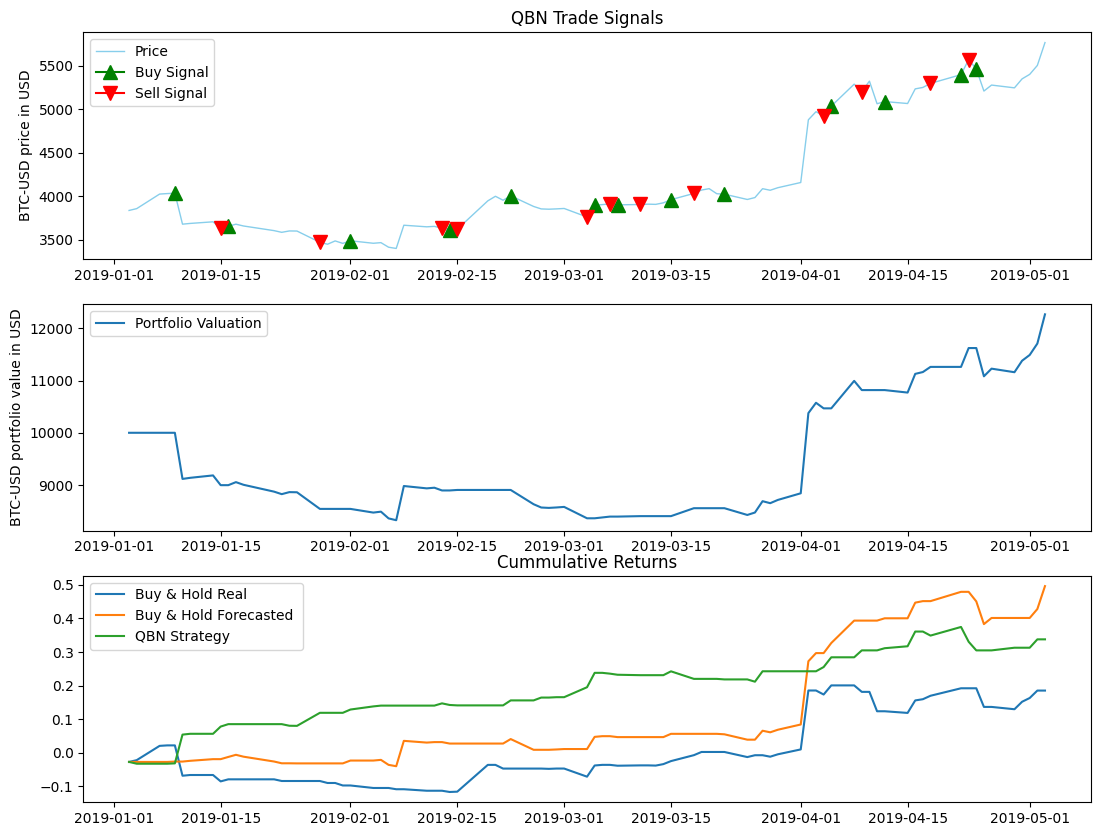

In [301]:
stock_prices = train_quantum_data['prices']
profit = (train_quantum_data['port_value'].iloc[-1]-initial_cash)
print("Total profit {}USD with return of {}%".format(round(profit,2),round(profit*100/initial_cash,2)))

plt.figure(figsize=(13,10))

plt.subplot(3,1,1)
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = system_variables['target symbol'])
plt.plot(stock_prices.index, BUY_PRICE_TRAIN, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, SELL_PRICE_TRAIN, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.ylabel('{} price in USD'.format(system_variables['target symbol']))
plt.legend(['Price','Buy Signal','Sell Signal'])
plt.title('QBN Trade Signals')


plt.subplot(3,1,2)
plt.plot(train_strategy.index,train_strategy['port_value'])
plt.legend(['Portfolio Valuation'])
plt.ylabel('{} portfolio value in USD'.format(system_variables['target symbol']))

plt.subplot(3,1,3)
plt.title('Cummulative Returns')
plt.plot(train_strategy.index,(1+ train_strategy['returns']*train_strategy['actual']).cumprod()-1)
plt.plot(train_strategy.index,(1+train_strategy['returns']*train_strategy['forecast']).cumprod()-1)
plt.plot(train_strategy.index,(1+train_strategy['returns']*train_strategy['signals']).cumprod()-1)
plt.legend(['Buy & Hold Real','Buy & Hold Forecasted ','QBN Strategy'])


plt.show()

Start date,2019-01-03
End date,2019-05-03
Total months,4
,Backtest
Annual return,139.4%
Cumulative returns,33.8%
Annual volatility,22.7%
Sharpe ratio,3.96
Calmar ratio,27.48
Stability,0.92
Max drawdown,-5.1%


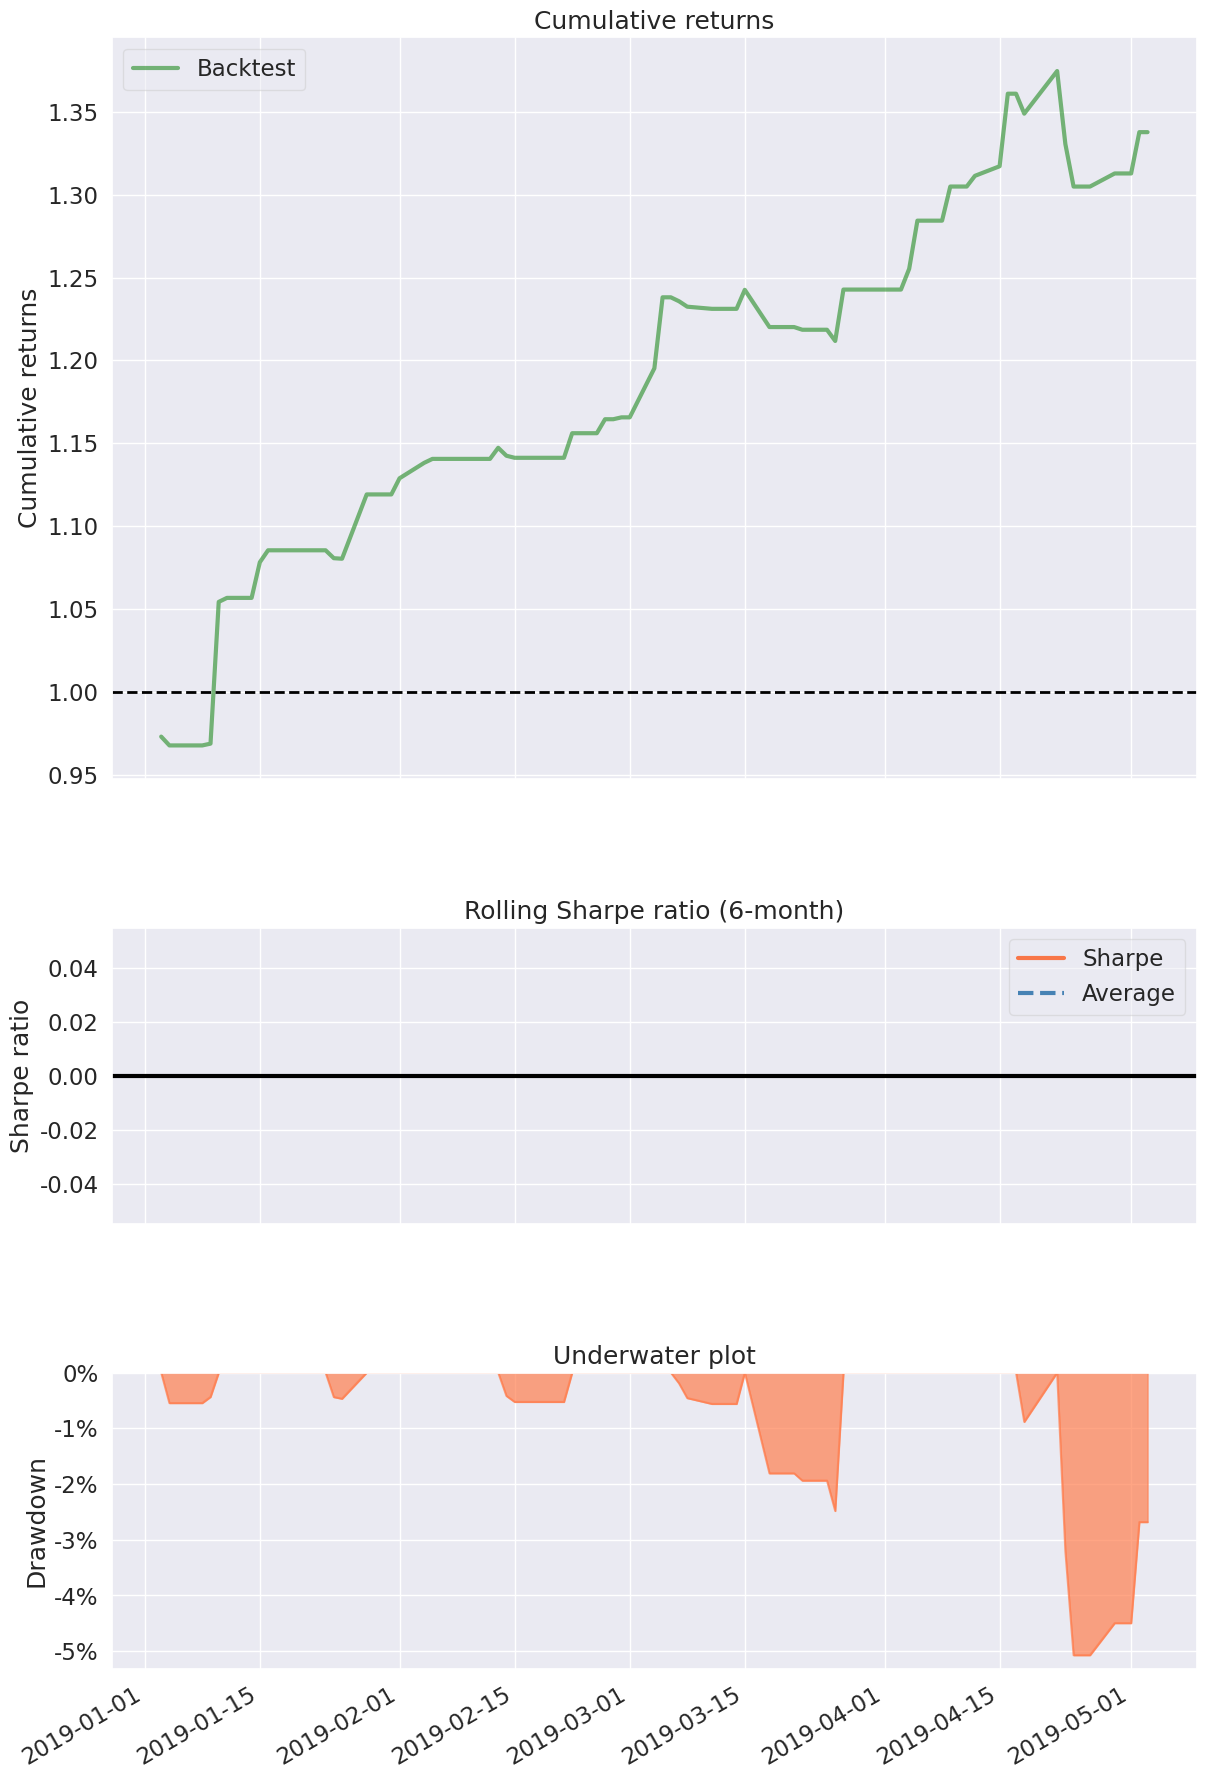

In [302]:
pf.create_simple_tear_sheet(train_strategy['returns']*train_strategy['signals'])

# **Forecasting with Trained QBN on Test Data**

In [303]:
test_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-05-07,0.014390,0.004455,-0.001432,-0.037476,-0.016512,-0.020800,0.251295
2019-05-08,0.026238,0.001833,0.000963,0.004679,-0.001605,0.013889,0.004141
2019-05-09,0.032106,0.000885,-0.000649,-0.021447,-0.003021,-0.010073,-0.015464
2019-05-10,0.033091,0.006561,-0.002116,-0.008050,0.003720,-0.000814,-0.160209
2019-05-13,0.225129,-0.000498,-0.001279,-0.061427,-0.024131,-0.020367,0.281172


#### **Scaling the Test Data:** Adjusting the Reference Level of Percentage Change Data

In [304]:
############ Shifting the mean/referenc e level of the data 
transformed_test_data = test_data.apply(lambda x: (x + 0.5),axis=1)
transformed_test_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-05-07,0.514390,0.504455,0.498568,0.462524,0.483488,0.479200,0.751295
2019-05-08,0.526238,0.501833,0.500963,0.504679,0.498395,0.513889,0.504141
2019-05-09,0.532106,0.500885,0.499351,0.478553,0.496979,0.489927,0.484536
2019-05-10,0.533091,0.506561,0.497884,0.491950,0.503720,0.499186,0.339791
2019-05-13,0.725129,0.499502,0.498721,0.438573,0.475869,0.479633,0.781172


#### **Converting Test Data to Quantum Data:** Scaling the Percentage Change Data between 0 to $\pi$ for $R_{y}(\theta)$ Gate

In [305]:
####### The Quantum Data: Angle data over bloch sphere ##############
test_angle_data = 2*np.arctan(np.sqrt((transformed_test_data)/(1-transformed_test_data)))
test_angle_data['actual'] = test_data[system_variables['target symbol']].apply(lambda x: 1 if x > 0 else 0)
test_angle_data['actual'] = test_angle_data['actual'].shift(-1)
test_angle_data.dropna(inplace=True)
test_angle_data['actual'] = test_angle_data['actual'].apply(np.int64)
test_angle_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2019-05-07,1.599580,1.579707,1.567933,1.495775,1.537767,1.529184,2.097389,1
2019-05-08,1.623297,1.574463,1.572723,1.580155,1.567585,1.598578,1.579078,1
2019-05-09,1.635052,1.572567,1.569498,1.527890,1.564753,1.550650,1.539864,1
2019-05-10,1.637026,1.583920,1.566563,1.554697,1.578237,1.569168,1.244625,1
2019-05-13,2.037851,1.569800,1.568238,1.447632,1.522516,1.530052,2.168014,1


In [306]:
####### The Quantum Data: Angle data over bloch sphere ##############
test_quantum_data = test_angle_data.applymap(lambda x: (np.pi/4-x/4) if x < np.pi/2 else ((3*np.pi/4)+x/4))
test_quantum_data['actual'] = test_data[system_variables['target symbol']].apply(lambda x: 1 if x > 0 else 0)
test_quantum_data['actual'] = test_quantum_data['actual'].shift(-1)
test_quantum_data.dropna(inplace=True)
test_quantum_data['actual'] = test_quantum_data['actual'].apply(np.int64)
test_quantum_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2019-05-07,2.756089,2.751121,0.393415,0.411454,0.400956,0.403102,2.880542,1
2019-05-08,2.762019,2.749810,2.749375,2.751233,0.393502,2.755839,2.750964,1
2019-05-09,2.764957,2.749336,0.393024,0.403426,0.394210,0.397736,0.400432,1
2019-05-10,2.765451,2.752174,0.393757,0.396724,2.750754,0.393106,0.474242,1
2019-05-13,2.865657,0.392948,0.393339,0.423490,0.404769,0.402885,2.898198,1


#### **QBN Strategy on Quantum Test Data Set:** Forecasting Price Movements & Implementation of QBN Trading Strategy using Qiskit Aer Quantum Simulator

In [307]:
initial_cash = system_variables['initial cash']


SIGNALS_TEST = []
STATES_TEST = []
BUY_PRICE_TEST = []
SELL_PRICE_TEST = []
POSITIONS_TEST = []
PORT_VALUE_TEST = []
CASH_TEST = []

test_log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
       'position':0,'portfolio value':initial_cash,'cash':initial_cash,
       'last purchase price': 0}


z = 0

for i in range(z,test_quantum_data.shape[0]):
    price = data0.loc[test_quantum_data.index[i]][0]
    row = np.append(test_quantum_data.iloc[i,:data.shape[1]].values,0)   
    my_data = encode_data(feature_map(row,method='default')) 
    qbn_circuit = my_data.compose(model_qc,qubits = range(my_data.num_qubits))
    cr = ClassicalRegister(1)

    qbn_circuit.add_register(cr)
    qbn_circuit.measure(-1,0)
    
    prob_dist, state = quantum_compute(service,qbn_circuit,
                                       backend = system_variables['Quantum Simulator'],
                                       sampler = system_variables['sampler'],
                                       optimization=system_variables['optimization'],
                                       num_shots= system_variables['num_shots'],
                                       seed=system_variables['seed'])


    if i == 0:
        test_log['state'] = state
        if state == 1:
            signal = 1
        else:
            signal = test_log['signal']

        state = test_log['state']
        buy_price, sell_price = test_log['buy_price'],test_log['sell_price']
        position, port_value, cash = test_log['position'],test_log['portfolio value'],test_log['cash']             
        new_log = test_log

    elif i == test_quantum_data.shape[0]-1:
        new_log = my_trade(state,price,test_log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        if new_log['position'] > 0:
            cash = new_log['position']*price
            position = 0
            port_value = cash
        else:
            position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    else:
        new_log = my_trade(state,price,test_log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    test_log = new_log
    SIGNALS_TEST.append(signal)
    BUY_PRICE_TEST.append(buy_price)
    SELL_PRICE_TEST.append(sell_price)
    STATES_TEST.append(state)
    POSITIONS_TEST.append(position)
    PORT_VALUE_TEST.append(port_value)
    CASH_TEST.append(cash)



    print("\n\n{}: The signal for the next day is {} with expected price movement of {}"
          .format(test_quantum_data.index[i].date(),scenario[signal],state))
    print("probability distributions are:",prob_dist)
    print(test_log,'\n\n')

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.81565 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 191.17212 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.439, '0': 0.561}


2019-05-07: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.439, '0': 0.561}
{'state': 0, 'buy_price': nan, 'sell_price': nan, 'signal': 0, 'position': 0, 'portfolio value': 10000, 'cash': 10000, 'last purchase price': 0} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 90.30819 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.533, '0': 0.467}


2019-05-08: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.533, '0': 0.467}
{'state': 1, 'signal': 1, 'position': 1.6715538668435945, 'cash': 0, 'buy_price': 5982.45751953125, 'sell_price': nan, 'last purchase price': 5982.45751953125, 'portfolio value': 10000.0} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 79.35786 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.43206 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 100.28481 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matr

The output probability distribution: {'1': 0.399, '0': 0.601}


2019-05-09: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.399, '0': 0.601}
{'state': 0, 'signal': -1, 'cash': 10321.057505942055, 'position': 0, 'buy_price': nan, 'sell_price': 6174.52880859375, 'last purchase price': 0, 'portfolio value': 10321.057505942055} 




INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.74627 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.50921 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 43.73240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.74059 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.10496 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.85792 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.13878 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
base_primitive._run:INFO:2024-08-06 01:15:14,593: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.427, '0': 0.573}


2019-05-10: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.427, '0': 0.573}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10321.057505942055, 'last purchase price': 0, 'portfolio value': 10321.057505942055} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 85.08253 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.63364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 77.60692 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.45, '0': 0.55}


2019-05-13: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.45, '0': 0.55}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10321.057505942055, 'last purchase price': 0, 'portfolio value': 10321.057505942055} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.30876 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.02557 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.15138 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.83720 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.68435 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02408 (ms)
base_primitive._run:INFO:2024-08-06 01:15:15,772: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.66426 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02027 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.595, '0': 0.405}


2019-05-14: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.595, '0': 0.405}
{'state': 1, 'signal': 1, 'position': 1.291033326983442, 'cash': 0, 'buy_price': 7994.416015625, 'sell_price': nan, 'last purchase price': 7994.416015625, 'portfolio value': 10321.057505942055} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 86.64823 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.09324 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 77.13485 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.52, '0': 0.48}


2019-05-15: The signal for the next day is HOLD !!! with expected price movement of 1
probability distributions are: {'1': 0.52, '0': 0.48}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.291033326983442, 'cash': 0, 'last purchase price': 7994.416015625, 'portfolio value': 10593.145301153283} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 56.15211 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.21800 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 14.10246 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.78976 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.21651 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02241 (ms)
base_primitive._run:INFO:2024-08-06 01:15:16,936: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.60265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.441, '0': 0.559}


2019-05-16: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.441, '0': 0.559}
{'state': 0, 'signal': -1, 'position': 1.291033326983442, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 7994.416015625, 'portfolio value': 10179.680531214235} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 92.34381 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.49004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 81.55656 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.596, '0': 0.404}


2019-05-17: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.596, '0': 0.404}
{'state': 1, 'signal': 1, 'position': 1.291033326983442, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 9481.213850469925} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.83366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.01384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.28590 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.86984 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.25274 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
base_primitive._run:INFO:2024-08-06 01:15:18,121: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.62029 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.594, '0': 0.406}


2019-05-20: The signal for the next day is HOLD !!! with expected price movement of 1
probability distributions are: {'1': 0.594, '0': 0.406}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.291033326983442, 'cash': 0, 'last purchase price': 0, 'portfolio value': 10300.262917877015} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 81.30336 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.87016 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 77.23880 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.458, '0': 0.542}


2019-05-21: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.458, '0': 0.542}
{'state': 0, 'signal': -1, 'cash': 10280.921372692199, 'position': 0, 'buy_price': nan, 'sell_price': 7963.32763671875, 'last purchase price': 0, 'portfolio value': 10280.921372692199} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 53.72667 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.30130 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 13.71217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.25379 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.60329 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
base_primitive._run:INFO:2024-08-06 01:15:19,297: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.59359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.59, '0': 0.41}


2019-05-23: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.59, '0': 0.41}
{'state': 1, 'signal': 1, 'position': 1.3043797717085024, 'cash': 0, 'buy_price': 7881.8466796875, 'sell_price': nan, 'last purchase price': 7881.8466796875, 'portfolio value': 10280.921372692199} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 79.90885 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.60115 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 78.55296 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.389, '0': 0.611}


2019-05-24: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.389, '0': 0.611}
{'state': 0, 'signal': -1, 'cash': 10418.565920720901, 'position': 0, 'buy_price': nan, 'sell_price': 7987.37158203125, 'last purchase price': 0, 'portfolio value': 10418.565920720901} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.78943 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 17.56859 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.23418 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.35662 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.37679 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
base_primitive._run:INFO:2024-08-06 01:15:20,475: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.76058 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01144 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.452, '0': 0.548}


2019-05-28: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.452, '0': 0.548}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 10418.565920720901, 'last purchase price': 0, 'portfolio value': 10418.565920720901} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 79.71668 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.01998 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)


The output probability distribution: {'1': 0.596, '0': 0.404}


2019-05-29: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.596, '0': 0.404}
{'state': 1, 'signal': 1, 'position': 1.2031388873428093, 'cash': 0, 'buy_price': 8659.4873046875, 'sell_price': nan, 'last purchase price': 8659.4873046875, 'portfolio value': 10418.565920720901} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1126.98483 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'c

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.538, '0': 0.462}


2019-05-30: The signal for the next day is HOLD !!! with expected price movement of 1
probability distributions are: {'1': 0.538, '0': 0.462}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.2031388873428093, 'cash': 0, 'last purchase price': 8659.4873046875, 'portfolio value': 10009.481074919551} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.33254 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 79.43630 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.587, '0': 0.413}


2019-05-31: The signal for the next day is HOLD !!! with expected price movement of 1
probability distributions are: {'1': 0.587, '0': 0.413}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.2031388873428093, 'cash': 0, 'last purchase price': 8659.4873046875, 'portfolio value': 10316.316739401558} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 85.37316 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.44, '0': 0.56}


2019-06-03: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.44, '0': 0.56}
{'state': 0, 'signal': -1, 'position': 1.2031388873428093, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 8659.4873046875, 'portfolio value': 9876.561251495523} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.55379 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 80.49893 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.458, '0': 0.542}


2019-06-04: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.458, '0': 0.542}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.2031388873428093, 'cash': 0, 'last purchase price': 8659.4873046875, 'portfolio value': 9273.519020133412} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 90.88874 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.389, '0': 0.611}


2019-06-05: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.389, '0': 0.611}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.2031388873428093, 'cash': 0, 'last purchase price': 8659.4873046875, 'portfolio value': 9413.637115425901} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.05059 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 78.37534 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.592, '0': 0.408}


2019-06-06: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.592, '0': 0.408}
{'state': 1, 'signal': 1, 'position': 1.2031388873428093, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 9410.980575363126} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 85.12306 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.68762 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 81.48646 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.452, '0': 0.548}


2019-06-07: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.452, '0': 0.548}
{'state': 0, 'signal': -1, 'cash': 9677.990462769574, 'position': 0, 'buy_price': nan, 'sell_price': 8043.951171875, 'last purchase price': 0, 'portfolio value': 9677.990462769574} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.98805 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.49478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 21.88635 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.00932 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.84481 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
base_primitive._run:INFO:2024-08-06 01:15:27,034: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.27189 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.456, '0': 0.544}


2019-06-10: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.456, '0': 0.544}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 9677.990462769574, 'last purchase price': 0, 'portfolio value': 9677.990462769574} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 88.39250 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.46510 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01073 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 83.20785 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.549, '0': 0.451}


2019-06-11: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.549, '0': 0.451}
{'state': 1, 'signal': 1, 'position': 1.220779411167033, 'cash': 0, 'buy_price': 7927.71435546875, 'sell_price': nan, 'last purchase price': 7927.71435546875, 'portfolio value': 9677.990462769574} 




INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.89226 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.37313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.16874 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 15.32030 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.77967 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.79570 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
base_primitive._run:INFO:2024-08-06 01:15:28,218: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.4, '0': 0.6}


2019-06-12: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.4, '0': 0.6}
{'state': 0, 'signal': -1, 'cash': 9944.295026927168, 'position': 0, 'buy_price': nan, 'sell_price': 8145.857421875, 'last purchase price': 0, 'portfolio value': 9944.295026927168} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 81.75254 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.66464 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 83.99892 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.602, '0': 0.398}


2019-06-13: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.602, '0': 0.398}
{'state': 1, 'signal': 1, 'position': 1.2081626843572033, 'cash': 0, 'buy_price': 8230.923828125, 'sell_price': nan, 'last purchase price': 8230.923828125, 'portfolio value': 9944.295026927168} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 110.54826 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 27.62556 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 33.50902 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 9.51242 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 5.87463 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02742 (ms)
base_primitive._run:INFO:2024-08-06 01:15:29,544: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.00305 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.563, '0': 0.437}


2019-06-14: The signal for the next day is HOLD !!! with expected price movement of 1
probability distributions are: {'1': 0.563, '0': 0.437}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.2081626843572033, 'cash': 0, 'last purchase price': 8230.923828125, 'portfolio value': 10503.564624072009} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 85.83784 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.31473 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 83.23383 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('u2', 1), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.525, '0': 0.475}


2019-06-17: The signal for the next day is HOLD !!! with expected price movement of 1
probability distributions are: {'1': 0.525, '0': 0.475}
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 1.2081626843572033, 'cash': 0, 'last purchase price': 8230.923828125, 'portfolio value': 11260.502142749225} 




INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.96514 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 10.42461 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 21.64340 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.95258 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.39985 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02694 (ms)
base_primitive._run:INFO:2024-08-06 01:15:30,718: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.73950 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02003 (ms)


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.41, '0': 0.59}


2019-06-18: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': -1, 'cash': 10972.24679666386, 'position': 0, 'buy_price': nan, 'sell_price': 9081.7626953125, 'last purchase price': 0, 'portfolio value': 10972.24679666386} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 88.77611 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('rccx', 3), ('cu', 2), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.599, '0': 0.401}


2019-06-19: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.599, '0': 0.401}
{'state': 1, 'signal': 1, 'position': 1.1831801775788249, 'cash': 0, 'buy_price': 9273.521484375, 'sell_price': nan, 'last purchase price': 9273.521484375, 'portfolio value': 10972.24679666386} 




INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01216 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.20189 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 80.62410 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.452, '0': 0.548}


2019-06-20: The signal for the next day is SELL !!! with expected price movement of 0
probability distributions are: {'1': 0.452, '0': 0.548}
{'state': 0, 'signal': -1, 'cash': 11272.34704549378, 'position': 0, 'buy_price': nan, 'sell_price': 9527.16015625, 'last purchase price': 0, 'portfolio value': 11272.34704549378} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 86.76362 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu3

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.36909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 84.38706 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.41, '0': 0.59}


2019-06-21: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.41, '0': 0.59}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 11272.34704549378, 'last purchase price': 0, 'portfolio value': 11272.34704549378} 




INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.98800 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.68423 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.73252 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.69325 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.10992 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.56303 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.92532 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.15619 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
base_primitive._run:INFO:2024-08-06 01:15:33,196: Submitting job using options {'op

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.421, '0': 0.579}


2019-06-24: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.421, '0': 0.579}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 11272.34704549378, 'last purchase price': 0, 'portfolio value': 11272.34704549378} 




INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 161.75795 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u2', 1), ('cu', 2), ('rccx', 3), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matrix', 'save_expval_var', 'ccx', 'kraus', 'mcswap', 'p', 'cu1', 'ry', 'x', 'multiplexer', 's', 'measure', 'cswap', 'id', 'mcry', 'set_matrix_product_state', 'ccz', 'quantum_channel', 'r', 'ryy', 'save_matrix_product_state', 'cu

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.96013 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 82.29637 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('rccx', 3), ('cu', 2), ('u2', 1), ('cx', 2), ('ccx', 3), ('measure', 1), ('x', 1), ('u1', 1), ('ry', 1), ('barrier', 8), ('unitary', 1)} to target basis {'cu2', 'initialize', 'rzz', 'mcz', 'ecr', 'swap', 'cx', 'mcr', 'if_else', 'while_loop', 'set_stabilizer', 'csx', 'rxx', 'rz', 'mcu', 'save_statevector', 'save_clifford', 'store', 'set_superop', 'save_unitary', 'save_amplitudes_sq', 'cp', 'save_expval', 'y', 'z', 'delay', 'set_statevector', 'h', 'u2', 'switch_case', 'superop', 'qerror_loc', 'mcp', 'sxdg', 'mcy', 'roerror', 'unitary', 'save_amplitudes', 'sdg', 'sx', 'mcu2', 'cz', 'set_density_matri

The output probability distribution: {'1': 0.44, '0': 0.56}


2019-06-25: The signal for the next day is HOLD !!! with expected price movement of 0
probability distributions are: {'1': 0.44, '0': 0.56}
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 11272.34704549378, 'last purchase price': 0, 'portfolio value': 11272.34704549378} 




INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.04005 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.65940 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.32822 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.90318 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.51105 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.00598 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02265 (ms)
base_primitive._run:INFO:2024-08-06 01:15:34,491: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}


Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 2523
The output probability distribution: {'1': 0.533, '0': 0.467}


2019-06-26: The signal for the next day is BUY !!! with expected price movement of 1
probability distributions are: {'1': 0.533, '0': 0.467}
{'state': 1, 'signal': 1, 'position': 0.8660223270348546, 'cash': 0, 'buy_price': 13016.2314453125, 'sell_price': nan, 'last purchase price': 13016.2314453125, 'portfolio value': 11272.34704549378} 




#### **QBN Strategy Results on Test Data**

In [308]:
test_quantum_data['prices'] = data0.loc[test_quantum_data.index].iloc[z:,0]
test_quantum_data['returns'] = data.loc[test_quantum_data.index].iloc[z:,0]
test_quantum_data['forecast'] = STATES_TEST
test_quantum_data['signals'] = SIGNALS_TEST
test_quantum_data['positions'] = POSITIONS_TEST
test_quantum_data['cash'] = CASH_TEST
test_quantum_data['port_value'] = PORT_VALUE_TEST



reference = test_quantum_data['actual']
score = accuracy_score(test_quantum_data['actual'],np.array(STATES_TEST))*100
print('\n\nQBN prediction accuracy score is:',round(accuracy_score(test_quantum_data['actual'],test_quantum_data['forecast'])*100,2),'%')
print("The confusion matrix is:\n",confusion_matrix(test_quantum_data['actual'],test_quantum_data['forecast']))

test_strategy = test_quantum_data.iloc[:,7:]
test_strategy.tail()



QBN prediction accuracy score is: 48.57 %
The confusion matrix is:
 [[ 7  6]
 [12 10]]


Ticker,actual,prices,returns,forecast,signals,positions,cash,port_value
Date,,,,,,,,
2019-06-20,1,9527.160156,0.027351,0,-1,0.0,11272.347045,11272.347045
2019-06-21,1,10144.556641,0.064804,0,0,0.0,11272.347045,11272.347045
2019-06-24,1,11011.102539,0.085420,0,0,0.0,11272.347045,11272.347045
2019-06-25,1,11790.916992,0.070821,0,0,0.0,11272.347045,11272.347045
2019-06-26,0,13016.231445,0.103920,1,1,0.0,11272.347045,11272.347045


In [309]:
print(classification_report(test_quantum_data['actual'],test_quantum_data['forecast']))

              precision    recall  f1-score   support

           0       0.37      0.54      0.44        13
           1       0.62      0.45      0.53        22

    accuracy                           0.49        35
   macro avg       0.50      0.50      0.48        35
weighted avg       0.53      0.49      0.49        35



#### **QBN Strategy Plots for Out of Sample Data**

Total profit 1272.35USD with return of 12.72%


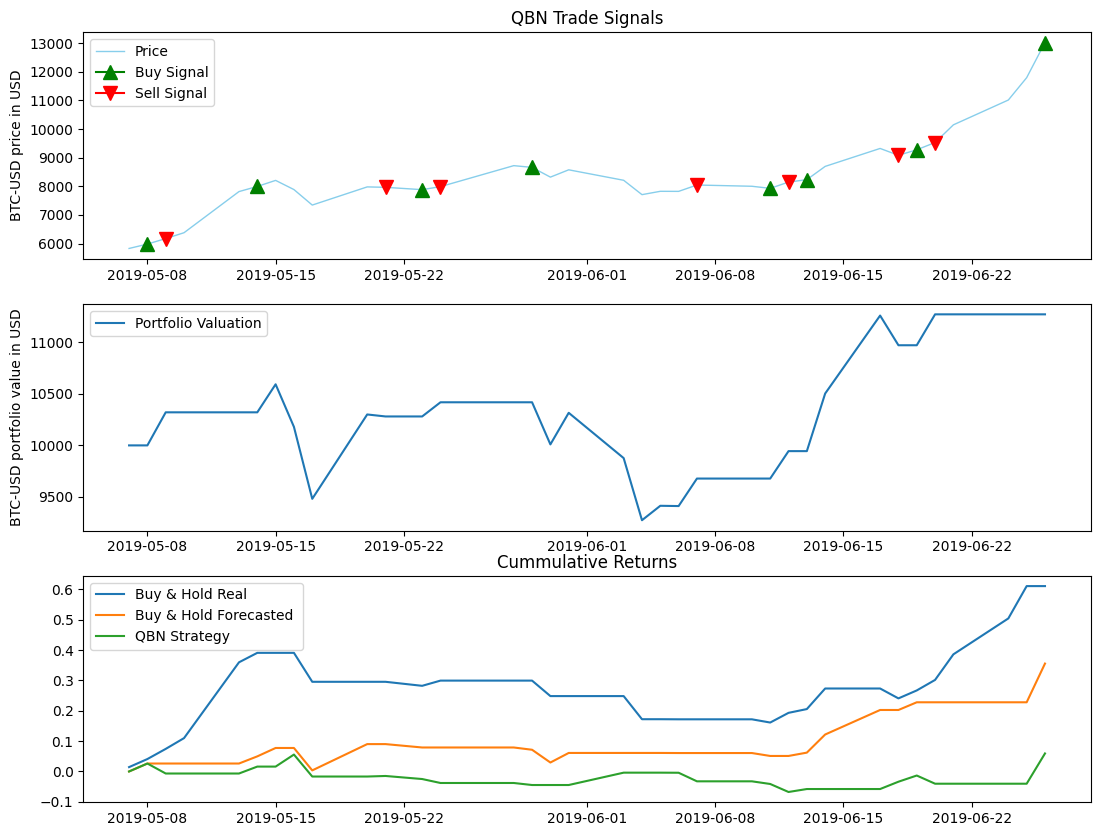

In [310]:
stock_prices = test_quantum_data['prices']
profit = (test_quantum_data['port_value'].iloc[-1]-initial_cash)
print("Total profit {}USD with return of {}%".format(round(profit,2),round(profit*100/initial_cash,2)))

plt.figure(figsize=(13,10))

plt.subplot(3,1,1)
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = system_variables['target symbol'])
plt.plot(stock_prices.index, BUY_PRICE_TEST, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, SELL_PRICE_TEST, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.ylabel('{} price in USD'.format(system_variables['target symbol']))
plt.legend(['Price','Buy Signal','Sell Signal'])
plt.title('QBN Trade Signals')


plt.subplot(3,1,2)
plt.plot(test_strategy.index,test_strategy['port_value'])
plt.legend(['Portfolio Valuation'])
plt.ylabel('{} portfolio value in USD'.format(system_variables['target symbol']))

plt.subplot(3,1,3)
plt.title('Cummulative Returns')
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['actual']).cumprod()-1)
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['forecast']).cumprod()-1)
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['signals']).cumprod()-1)
plt.legend(['Buy & Hold Real','Buy & Hold Forecasted ','QBN Strategy'])


plt.show()

Start date,2019-05-07
End date,2019-06-26
Total months,1
,Backtest
Annual return,51.5%
Cumulative returns,5.9%
Annual volatility,43.0%
Sharpe ratio,1.17
Calmar ratio,4.41
Stability,0.18
Max drawdown,-11.7%


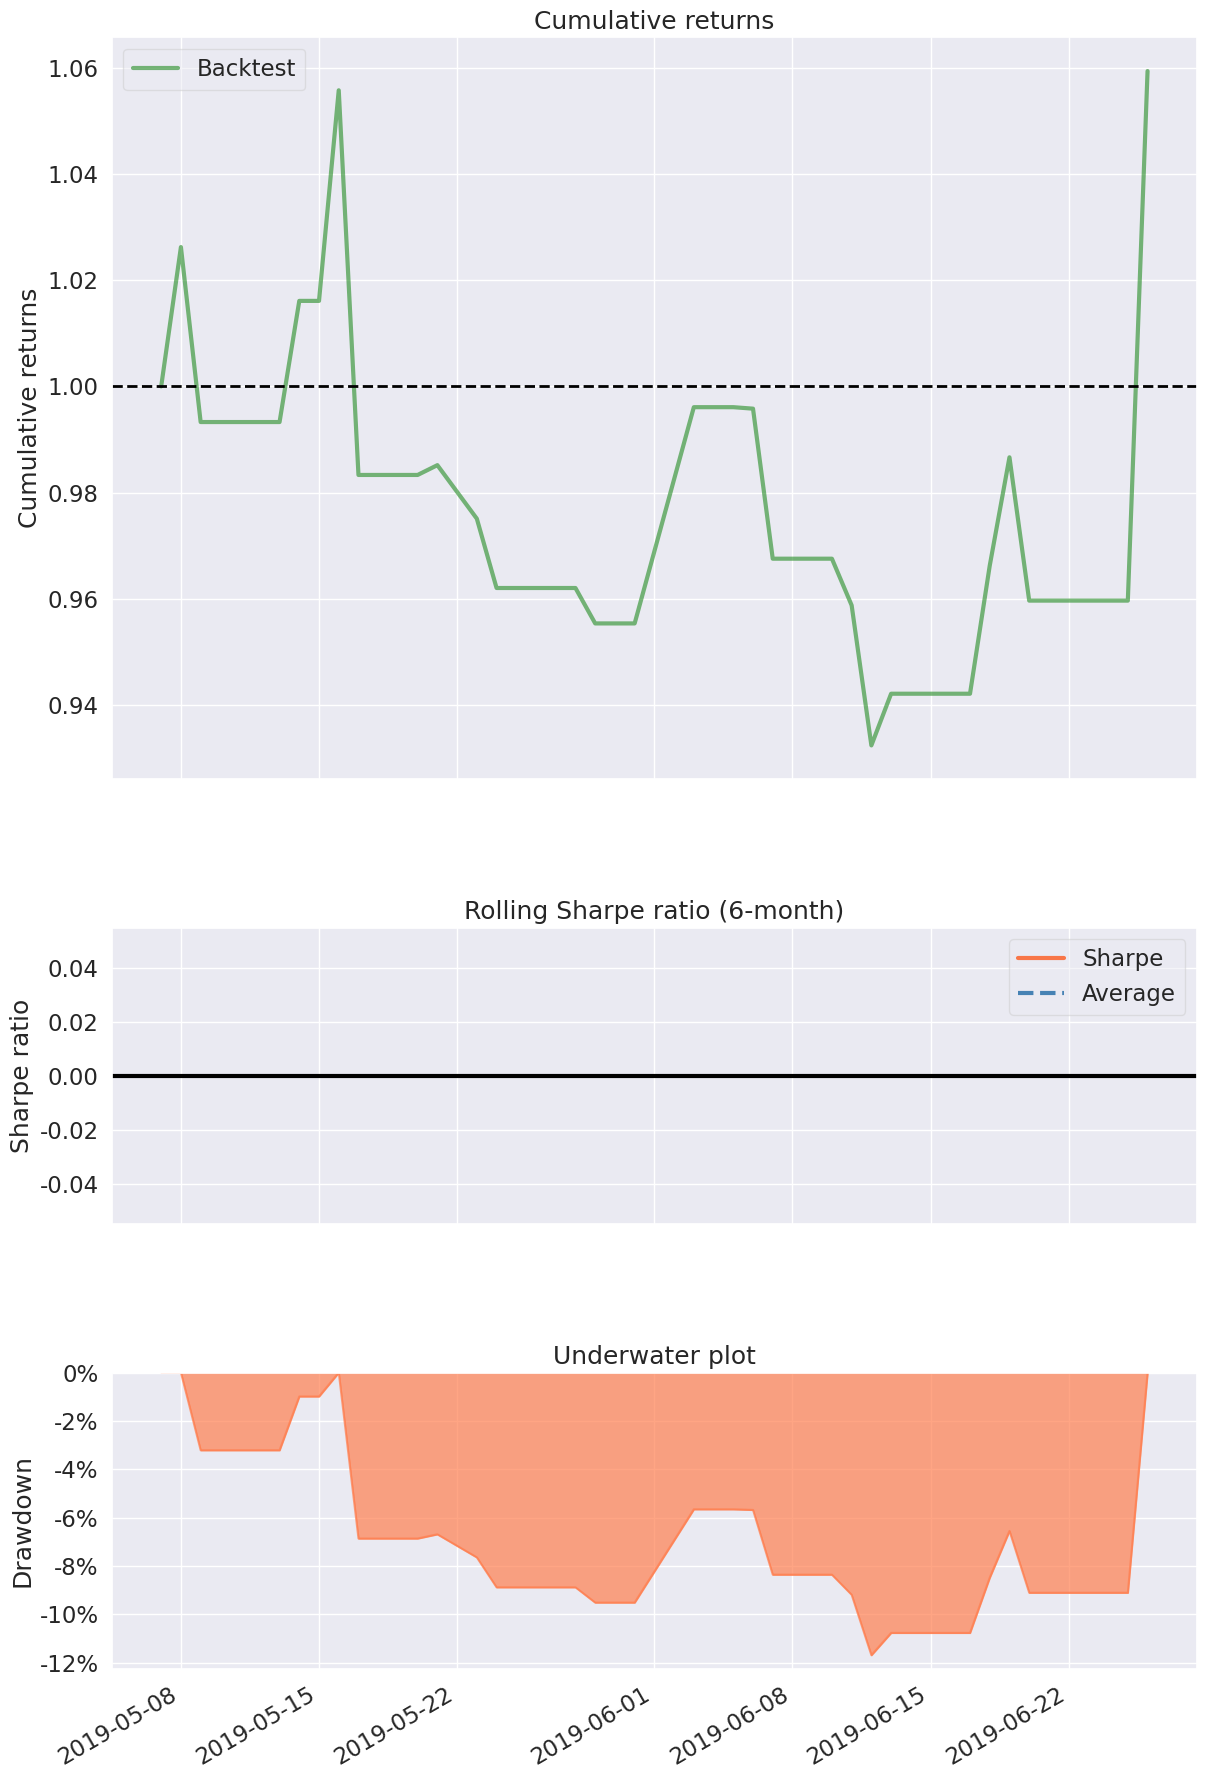

In [311]:
pf.create_simple_tear_sheet(test_strategy['returns']*test_strategy['signals'])

# **On Real Hardware**
#### **QBN Execution on Real IBM Quantum Computer:** Exploring the Probable Events 

In [312]:
# Select the QPU
if system_variables['Quantum Computer'] == 'least_busy':
    qpu_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
else:
    qpu_backend = service.get_backend(system_variables['Quantum Computer'])

print("The target Quantum Computer is:",qpu_backend)

The target Quantum Computer is: <IBMBackend('ibm_osaka')>


In [313]:
prob_dist, state = quantum_compute(service,qbn_qc,                                       
                                   backend = qpu_backend,
                                   sampler = system_variables['sampler'],
                                   optimization= system_variables['optimization'],
                                   num_shots = system_variables['num_shots'],
                                   seed = system_variables['seed'])

# print(prob_dist)

backend_converter.convert_to_target:INFO:2024-08-06 01:16:03,279: Gate calibration for instruction measure on qubits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126) is found in the PulseDefaults payload. However, this entry is not defined in the gate mapping of Target. This calibration is ignored.
backend_converter.convert_to_target:INFO:2024-08-06 01:16:03,281: Gate calibration for instruction u1 on qubits (0,) is found in the PulseDefaults payload. However, this entry is not defined in the gate mapping of Target. T

Circuit pre-transpilation depth is: 422
Circuit post-transpilation depth is: 11512


base_primitive._run:INFO:2024-08-06 01:16:11,277: Submitting job using options {'options': {'simulator': {'seed_simulator': 20427891}}, 'version': 2, 'support_qiskit': True}


In [ ]:
######## Plotting the distribution #############

m = 500 # take m largest probability values
top_keys = heapq.nlargest(m, prob_dist, key=prob_dist.get)
top_states = {key: prob_dist[key] for key in top_keys}
print(f"\n\n State with max probability is: {list(top_states.keys())[0]}")

plot_histogram(top_states,figsize=(14,3))